SUMME DER AUSLEIHEN(A) UND RÜCKGABEN(R) AN EINER STATION AM TAG t

In [1]:
from datetime import datetime, date
import pandas as pd
import csv
import numpy as np 
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import pmdarima as pm
from pmdarima.arima import ADFTest
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

In c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed tw

Ausgangsdaten der Ausleihen und Rückgaben für die Station 'Grove St PATH' von 2018-01-01 bis 2022-02-28

In [2]:
data_A = pd.read_csv(r'C:\Users\emres\OneDrive\BA\Data\bike_station_A_newsplit.csv')
data_R = pd.read_csv(r'C:\Users\emres\OneDrive\BA\Data\bike_station_R_newsplit.csv')

In [3]:
data_A = data_A.rename(columns={'TotalRent_A': 'Total_A', 'starttime': 'time'})
data_R = data_R.rename(columns={'TotalRent_R': 'Total_R', 'stoptime': 'time'})

In [4]:
data_A.Total_A = data_A.Total_A.astype(int)
data_R.Total_R = data_R.Total_R.astype(int)

data_A['time'] = pd.to_datetime(data_A['time']).dt.strftime('%Y-%m-%d')
data_R['time'] = pd.to_datetime(data_R['time']).dt.strftime('%Y-%m-%d')

data_A.time = pd.to_datetime(data_A.time)
data_R.time = pd.to_datetime(data_R.time)

data_A
data_R

time  Total_R
0    2018-01-01       12
1    2018-01-02       60
2    2018-01-03       81
3    2018-01-04       11
4    2018-01-05       17
...         ...      ...
1515 2022-02-24       83
1516 2022-02-25       49
1517 2022-02-26       48
1518 2022-02-27       48
1519 2022-02-28       84

[1520 rows x 2 columns]

In [5]:
data_A = data_A.set_index('time')
data_R = data_R.set_index('time')

In [6]:
data_R

Total_R
time               
2018-01-01       12
2018-01-02       60
2018-01-03       81
2018-01-04       11
2018-01-05       17
...             ...
2022-02-24       83
2022-02-25       49
2022-02-26       48
2022-02-27       48
2022-02-28       84

[1520 rows x 1 columns]

-------------------ARIMA-------------------

In [7]:
bike_arima_A = data_A
bike_arima_R = data_R

---Darstellung der Ausleihen und Rückgaben in einer Grafik

<AxesSubplot:xlabel='time'>

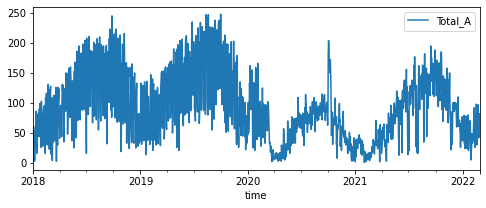

In [8]:
bike_arima_A.plot(figsize=(8,3))

<AxesSubplot:xlabel='time'>

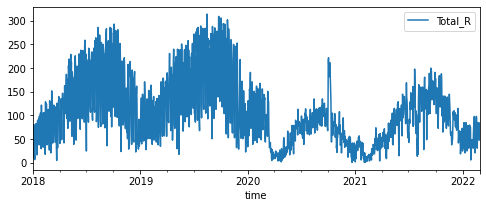

In [9]:
bike_arima_R.plot(figsize=(8,3))

---Ermittlung der Werte 'd' & 'D' vor auto_arima ---> (verkürzt die Laufzeit von auto_arima)

In [10]:
pm.arima.ndiffs(bike_arima_A, alpha=0.05, test='adf', max_d=3)#---- 'd' von Ausleihen

0

In [11]:
pm.arima.ndiffs(bike_arima_R, alpha=0.05, test='adf', max_d=3)#---- 'd' von Rückgaben

0

In [12]:
pm.arima.nsdiffs(bike_arima_A, m=7, max_D=3, test='ocsb')#---- 'D' von Ausleihen

0

In [13]:
pm.arima.nsdiffs(bike_arima_R, m=7, max_D=3, test='ocsb')#---- 'D' von Rückgaben

0

---Einbindung der Wetterdaten und zusammenfügen mit den Bikedaten 

In [14]:
weather = pd.read_csv(r'C:\Users\emres\OneDrive\BA\Data\weather.csv')

In [15]:
weather['time'] = pd.to_datetime(weather['time']).dt.strftime('%Y-%m-%d')
weather.time = pd.to_datetime(weather.time)
weather = weather.set_index('time')
weather

avg_temp_C°  precipitation_mm  windspeed_km/h
time                                                     
2017-01-01          7.9               0.0             9.8
2017-01-02          4.9               7.4            20.3
2017-01-03          5.8              10.9            26.9
2017-01-04          7.1               0.0            19.5
2017-01-05         -0.1               0.0            22.0
...                 ...               ...             ...
2022-07-04         26.2               NaN            13.8
2022-07-05         22.5               NaN            14.0
2022-07-06         24.2               NaN            14.4
2022-07-07         24.7               NaN            12.4
2022-07-08         25.8               NaN            13.8

[2015 rows x 3 columns]

In [16]:
bike_arima_AW = pd.merge(bike_arima_A, weather, on='time', how='left')
bike_arima_RW = pd.merge(bike_arima_R, weather, on='time', how='left')

In [17]:
bike_arima_AW

Total_A  avg_temp_C°  precipitation_mm  windspeed_km/h
time                                                              
2018-01-01       13         -8.6               0.0             9.6
2018-01-02       61         -6.0               0.0            19.9
2018-01-03       51         -4.0               0.0            13.0
2018-01-04        3         -2.9              18.0            10.5
2018-01-05        9         -8.1               0.0             9.1
...             ...          ...               ...             ...
2022-02-24       82          1.1               0.2            11.5
2022-02-25       42          1.7              11.2            14.8
2022-02-26       46         -0.1               0.0            12.0
2022-02-27       46          3.5               0.7            18.9
2022-02-28       82          1.3               0.0             8.9

[1520 rows x 4 columns]

---Durchführung von auto_arima zur Ermittlung des ARIMA-Modells

In [18]:
### ARIMA-Modell für die Ausleihen
model_A = pm.auto_arima(bike_arima_AW['Total_A'], max_p=3, d=0, max_q=3, max_P=3, D=0, max_Q=3, m=7,
                    seasonal=True, trace=False, error_action='ignore', suppress_warnings=True, stepwise=True)
print(model_A.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1520
Model:             SARIMAX(1, 0, 0)x(3, 0, [1], 7)   Log Likelihood               -7248.384
Date:                             Mon, 18 Jul 2022   AIC                          14510.768
Time:                                     13:29:53   BIC                          14548.054
Sample:                                          0   HQIC                         14524.649
                                            - 1520                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.0712      0.962      4.231      0.000       2.185       5.957
ar.L1          0.4751      

In [19]:
### ARIMA-Modell für die Rückgaben
model_R = pm.auto_arima(bike_arima_RW['Total_R'], max_p=3, d=0, max_q=3, max_P=3, D=0, max_Q=3, m=7,
                        seasonal=True, trace=False, error_action='ignore', suppress_warnings=True, stepwise=True)
print(model_R.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1520
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -7421.294
Date:                             Mon, 18 Jul 2022   AIC                          14856.588
Time:                                     13:32:45   BIC                          14893.873
Sample:                                          0   HQIC                         14870.469
                                            - 1520                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0634      0.350      3.034      0.002       0.376       1.750
ar.L1          0.4168      

---Unterteilung in train & test Daten

In [20]:
train_arima_A = bike_arima_AW[:1461]
test_arima_A = bike_arima_AW[-59:]

train_arima_R = bike_arima_RW[:1461]
test_arima_R = bike_arima_RW[-59:]

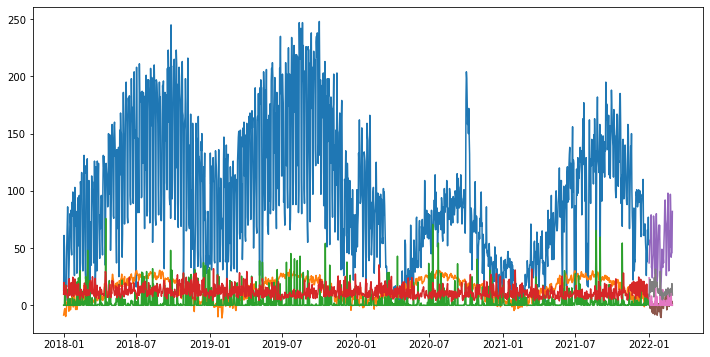

In [21]:
plt.figure(figsize=(12,6))
plt.plot(train_arima_A)
plt.plot(test_arima_A)

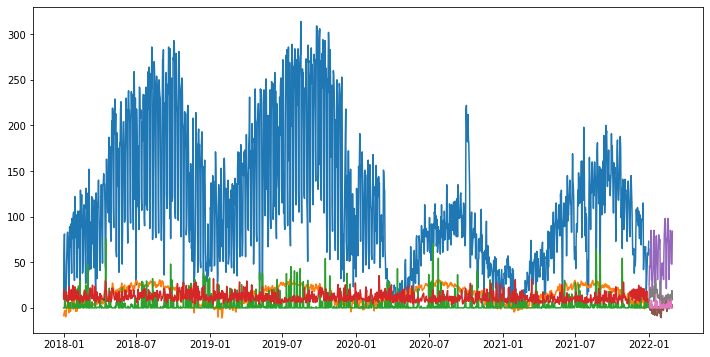

In [22]:
plt.figure(figsize=(12,6))
plt.plot(train_arima_R)
plt.plot(test_arima_R)

---Durchführung des SARIMAX-Modells mit den exog Variablen

--Ausleihen

In [23]:
model_train_A_ex1 = SARIMAX(train_arima_A['Total_A'], exog=train_arima_A['avg_temp_C°'], order=(1, 0, 0), seasonal_order=(3, 0, 1, 7))
model_result_train_A_ex1 = model_train_A_ex1.fit()
model_result_train_A_ex1.summary()

c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             Total_A   No. Observations:                 1461
Model:             SARIMAX(1, 0, 0)x(3, 0, [1], 7)   Log Likelihood               -6914.191
Date:                             Mon, 18 Jul 2022   AIC                          13842.383
Time:                                     13:32:55   BIC                          13879.391
Sample:                                 01-01-2018   HQIC                         13856.188
                                      - 12-31-2021                                         
Covariance Type:                               opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
avg_temp_C°     2.5945      0.196     13.263      0.000       2.211       2.978
ar.L1           0.4420      0.019     22.778      0.000       0.404       0.480
ar.S.L7         1.0881      0.035     31.293      0.000       1.020       1.156
ar.S.L14       -0.1113      0.033     -3.385      0.001      -0.176      -0.047
ar.S.L21        0.0142      0.027      0.525      0.599      -0.039       0.067
ma.S.L7        -0.7997      0.028    -28.380      0.000      -0.855      -0.744
sigma2        748.4846     21.835     34.279      0.000     705.689     791.280
===================================================================================
Ljung-Box (Q):                      173.41   Jarque-Bera (JB):               306.33
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                            -0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
model_train_A_ex2 = SARIMAX(train_arima_A['Total_A'], exog=train_arima_A['precipitation_mm'], order=(1, 0, 0), seasonal_order=(3, 0, 1, 7))
model_result_train_A_ex2 = model_train_A_ex2.fit()
model_result_train_A_ex2.summary()

c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             Total_A   No. Observations:                 1461
Model:             SARIMAX(1, 0, 0)x(3, 0, [1], 7)   Log Likelihood               -6817.037
Date:                             Mon, 18 Jul 2022   AIC                          13648.073
Time:                                     13:33:09   BIC                          13685.081
Sample:                                 01-01-2018   HQIC                         13661.878
                                      - 12-31-2021                                         
Covariance Type:                               opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
precipitation_mm    -1.3479      0.047    -28.663      0.000      -1.440      -1.256
ar.L1                0.5322      0.019     27.429      0.000       0.494       0.570
ar.S.L7              0.9539      0.043     22.180      0.000       0.870       1.038
ar.S.L14            -0.0174      0.034     -0.512      0.609      -0.084       0.049
ar.S.L21             0.0511      0.031      1.652      0.098      -0.010       0.112
ma.S.L7             -0.6679      0.039    -17.313      0.000      -0.744      -0.592
sigma2             655.1030     19.256     34.021      0.000     617.363     692.843
===================================================================================
Ljung-Box (Q):                      271.53   Jarque-Bera (JB):               174.10
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
model_train_A_ex3 = SARIMAX(train_arima_A['Total_A'], exog=train_arima_A['windspeed_km/h'], order=(1, 0, 0), seasonal_order=(3, 0, 1, 7))
model_result_train_A_ex3 = model_train_A_ex3.fit()
model_result_train_A_ex3.summary()

c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             Total_A   No. Observations:                 1461
Model:             SARIMAX(1, 0, 0)x(3, 0, [1], 7)   Log Likelihood               -6980.707
Date:                             Mon, 18 Jul 2022   AIC                          13975.414
Time:                                     13:33:21   BIC                          14012.422
Sample:                                 01-01-2018   HQIC                         13989.219
                                      - 12-31-2021                                         
Covariance Type:                               opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
windspeed_km/h    -0.6064      0.141     -4.304      0.000      -0.882      -0.330
ar.L1              0.4827      0.020     23.629      0.000       0.443       0.523
ar.S.L7            1.0269      0.040     25.699      0.000       0.949       1.105
ar.S.L14          -0.0537      0.033     -1.640      0.101      -0.118       0.010
ar.S.L21           0.0168      0.029      0.582      0.560      -0.040       0.073
ma.S.L7           -0.7222      0.035    -20.378      0.000      -0.792      -0.653
sigma2           818.6363     23.818     34.371      0.000     771.954     865.318
===================================================================================
Ljung-Box (Q):                      269.40   Jarque-Bera (JB):               326.22
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                            -0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

--Rückgaben

In [26]:
model_train_R_ex1 = SARIMAX(train_arima_R['Total_R'], exog=train_arima_R['avg_temp_C°'], order=(3, 0, 0), seasonal_order=(1, 0, 1, 7))
model_result_train_R_ex1 = model_train_R_ex1.fit()
model_result_train_R_ex1.summary()

c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             Total_R   No. Observations:                 1461
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -7106.942
Date:                             Mon, 18 Jul 2022   AIC                          14227.885
Time:                                     13:33:25   BIC                          14264.893
Sample:                                 01-01-2018   HQIC                         14241.690
                                      - 12-31-2021                                         
Covariance Type:                               opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
avg_temp_C°     2.6033      0.245     10.611      0.000       2.122       3.084
ar.L1           0.3930      0.019     20.669      0.000       0.356       0.430
ar.L2           0.0907      0.026      3.532      0.000       0.040       0.141
ar.L3           0.1329      0.023      5.844      0.000       0.088       0.178
ar.S.L7         0.9871      0.003    296.298      0.000       0.981       0.994
ma.S.L7        -0.7607      0.017    -45.051      0.000      -0.794      -0.728
sigma2        974.8968     25.469     38.278      0.000     924.979    1024.814
===================================================================================
Ljung-Box (Q):                       84.19   Jarque-Bera (JB):               806.19
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                            -0.75
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
model_train_R_ex2 = SARIMAX(train_arima_R['Total_R'], exog=train_arima_R['precipitation_mm'], order=(3, 0, 0), seasonal_order=(1, 0, 1, 7))
model_result_train_R_ex2 = model_train_R_ex2.fit()
model_result_train_R_ex2.summary()

c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             Total_R   No. Observations:                 1461
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -7017.323
Date:                             Mon, 18 Jul 2022   AIC                          14048.647
Time:                                     13:33:28   BIC                          14085.655
Sample:                                 01-01-2018   HQIC                         14062.452
                                      - 12-31-2021                                         
Covariance Type:                               opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
precipitation_mm    -1.3936      0.057    -24.623      0.000      -1.505      -1.283
ar.L1                0.4543      0.020     22.854      0.000       0.415       0.493
ar.L2                0.1073      0.026      4.141      0.000       0.056       0.158
ar.L3                0.1416      0.023      6.158      0.000       0.097       0.187
ar.S.L7              0.9867      0.003    297.575      0.000       0.980       0.993
ma.S.L7             -0.7253      0.017    -42.941      0.000      -0.758      -0.692
sigma2             861.7076     22.307     38.630      0.000     817.988     905.428
===================================================================================
Ljung-Box (Q):                       89.84   Jarque-Bera (JB):               545.82
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.47   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
model_train_R_ex3 = SARIMAX(train_arima_R['Total_R'], exog=train_arima_R['windspeed_km/h'], order=(3, 0, 0), seasonal_order=(1, 0, 1, 7))
model_result_train_R_ex3 = model_train_R_ex3.fit()
model_result_train_R_ex3.summary()

c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             Total_R   No. Observations:                 1461
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -7174.822
Date:                             Mon, 18 Jul 2022   AIC                          14363.644
Time:                                     13:33:32   BIC                          14400.652
Sample:                                 01-01-2018   HQIC                         14377.449
                                      - 12-31-2021                                         
Covariance Type:                               opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
windspeed_km/h    -1.4088      0.182     -7.737      0.000      -1.766      -1.052
ar.L1              0.4173      0.021     19.693      0.000       0.376       0.459
ar.L2              0.1675      0.028      5.958      0.000       0.112       0.223
ar.L3              0.2456      0.026      9.507      0.000       0.195       0.296
ar.S.L7            0.9811      0.004    225.986      0.000       0.973       0.990
ma.S.L7           -0.7739      0.020    -38.374      0.000      -0.813      -0.734
sigma2          1192.7330     35.222     33.864      0.000    1123.700    1261.766
===================================================================================
Ljung-Box (Q):                      118.52   Jarque-Bera (JB):               675.49
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

---Abschnitt der Prognose für die Zukunft---

In [29]:
from pandas.tseries.offsets import DateOffset

In [30]:
bike_arima_AW_new = bike_arima_AW.copy()
bike_arima_RW_new = bike_arima_RW.copy()

In [31]:
future_dates_AW = [bike_arima_AW_new.index[-60] + DateOffset(days = x) for x in range(0,88)]
future_dates_RW = [bike_arima_RW_new.index[-60] + DateOffset(days = x) for x in range(0,88)]
future_dates_RW

[Timestamp('2021-12-31 00:00:00'),
 Timestamp('2022-01-01 00:00:00'),
 Timestamp('2022-01-02 00:00:00'),
 Timestamp('2022-01-03 00:00:00'),
 Timestamp('2022-01-04 00:00:00'),
 Timestamp('2022-01-05 00:00:00'),
 Timestamp('2022-01-06 00:00:00'),
 Timestamp('2022-01-07 00:00:00'),
 Timestamp('2022-01-08 00:00:00'),
 Timestamp('2022-01-09 00:00:00'),
 Timestamp('2022-01-10 00:00:00'),
 Timestamp('2022-01-11 00:00:00'),
 Timestamp('2022-01-12 00:00:00'),
 Timestamp('2022-01-13 00:00:00'),
 Timestamp('2022-01-14 00:00:00'),
 Timestamp('2022-01-15 00:00:00'),
 Timestamp('2022-01-16 00:00:00'),
 Timestamp('2022-01-17 00:00:00'),
 Timestamp('2022-01-18 00:00:00'),
 Timestamp('2022-01-19 00:00:00'),
 Timestamp('2022-01-20 00:00:00'),
 Timestamp('2022-01-21 00:00:00'),
 Timestamp('2022-01-22 00:00:00'),
 Timestamp('2022-01-23 00:00:00'),
 Timestamp('2022-01-24 00:00:00'),
 Timestamp('2022-01-25 00:00:00'),
 Timestamp('2022-01-26 00:00:00'),
 Timestamp('2022-01-27 00:00:00'),
 Timestamp('2022-01-

In [32]:
future_date_df_AW = pd.DataFrame(index = future_dates_AW[1:], columns = bike_arima_AW_new.columns)
future_date_df_RW = pd.DataFrame(index = future_dates_RW[1:], columns = bike_arima_RW_new.columns)
future_date_df_RW.tail()

Total_R avg_temp_C° precipitation_mm windspeed_km/h
2022-03-24     NaN         NaN              NaN            NaN
2022-03-25     NaN         NaN              NaN            NaN
2022-03-26     NaN         NaN              NaN            NaN
2022-03-27     NaN         NaN              NaN            NaN
2022-03-28     NaN         NaN              NaN            NaN

In [33]:
bike_arima_AW_new = pd.concat([bike_arima_AW_new, future_date_df_AW[-87:]])
bike_arima_RW_new = pd.concat([bike_arima_RW_new, future_date_df_RW[-87:]])

In [34]:
bike_arima_AW_new = bike_arima_AW_new[~bike_arima_AW_new.index.duplicated(keep='first')]
bike_arima_AW_new.index.name = 'time'
bike_arima_RW_new = bike_arima_RW_new[~bike_arima_RW_new.index.duplicated(keep='first')]
bike_arima_RW_new.index.name = 'time'

In [35]:
cols_to_use_AW = bike_arima_AW_new.columns.difference(weather.columns)
cols_to_use_RW = bike_arima_RW_new.columns.difference(weather.columns)

In [36]:
bike_arima_AW_new = pd.merge(bike_arima_AW_new[cols_to_use_AW], weather, on='time')
bike_arima_RW_new = pd.merge(bike_arima_RW_new[cols_to_use_RW], weather, on='time')

In [37]:
bike_arima_AW_new
bike_arima_RW_new

Total_R  avg_temp_C°  precipitation_mm  windspeed_km/h
time                                                             
2018-01-01      12         -8.6               0.0             9.6
2018-01-02      60         -6.0               0.0            19.9
2018-01-03      81         -4.0               0.0            13.0
2018-01-04      11         -2.9              18.0            10.5
2018-01-05      17         -8.1               0.0             9.1
...            ...          ...               ...             ...
2022-03-24     NaN          6.4              15.6            27.1
2022-03-25     NaN         10.1               1.0            12.9
2022-03-26     NaN          9.6               1.8            16.6
2022-03-27     NaN          5.1               0.2            11.3
2022-03-28     NaN         -1.0               1.7             9.6

[1548 rows x 4 columns]

In [38]:
history_arima_A = bike_arima_AW_new[:1461]
future_arima_A = bike_arima_AW_new[-87:]

history_arima_R = bike_arima_RW_new[:1461]
future_arima_R = bike_arima_RW_new[-87:]

In [39]:
bike_arima_AW_new['forecast_avg_temp_C°'] = model_result_train_A_ex1.predict(start=len(history_arima_A), end=len(bike_arima_AW_new)-1, exog=future_arima_A['avg_temp_C°'])
bike_arima_AW_new['forecast_precipitation_mm'] = model_result_train_A_ex2.predict(start=len(history_arima_A), end=len(bike_arima_AW_new)-1, exog=future_arima_A['precipitation_mm'])
bike_arima_AW_new['forecast_windspeed_km/h'] = model_result_train_A_ex3.predict(start=len(history_arima_A), end=len(bike_arima_AW_new)-1, exog=future_arima_A['windspeed_km/h'])

bike_arima_RW_new['forecast_avg_temp_C°'] = model_result_train_R_ex1.predict(start=len(history_arima_R), end=len(bike_arima_RW_new)-1, exog=future_arima_R['avg_temp_C°'])
bike_arima_RW_new['forecast_precipitation_mm'] = model_result_train_R_ex2.predict(start=len(history_arima_R), end=len(bike_arima_RW_new)-1, exog=future_arima_R['precipitation_mm'])
bike_arima_RW_new['forecast_windspeed_km/h'] = model_result_train_R_ex3.predict(start=len(history_arima_R), end=len(bike_arima_RW_new)-1, exog=future_arima_R['windspeed_km/h'])

In [40]:
bike_arima_AW_new.tail(28)

Total_A  avg_temp_C°  precipitation_mm  windspeed_km/h  \
time                                                                
2022-03-01     NaN          4.4               0.2            10.7   
2022-03-02     NaN          7.9               0.0             9.4   
2022-03-03     NaN          4.7               1.9            10.3   
2022-03-04     NaN         -0.4               0.0            11.8   
2022-03-05     NaN          4.1               0.0             7.7   
2022-03-06     NaN         12.4               1.9            15.1   
2022-03-07     NaN         17.8               4.1            15.5   
2022-03-08     NaN          7.3               0.2             8.4   
2022-03-09     NaN          3.5              11.4            13.3   
2022-03-10     NaN          5.0               0.0             7.5   
2022-03-11     NaN          7.2               0.2             7.7   
2022-03-12     NaN          2.9              13.8             6.5   
2022-03-13     NaN         -3.1               0.0            24.1   
2022-03-14     NaN          6.8               0.0            10.2   
2022-03-15     NaN         11.9               0.5             7.0   
2022-03-16     NaN         12.9               0.7             9.1   
2022-03-17     NaN          9.5               2.2            17.8   
2022-03-18     NaN         13.2               0.2             7.4   
2022-03-19     NaN         14.0              17.9             8.2   
2022-03-20     NaN         12.2               0.2            10.5   
2022-03-21     NaN         11.8               0.9             7.7   
2022-03-22     NaN         11.5               0.0             6.2   
2022-03-23     NaN          6.8               4.1            17.9   
2022-03-24     NaN          6.4              15.6            27.1   
2022-03-25     NaN         10.1               1.0            12.9   
2022-03-26     NaN          9.6               1.8            16.6   
2022-03-27     NaN          5.1               0.2            11.3   
2022-03-28     NaN         -1.0               1.7             9.6   

            forecast_avg_temp_C°  forecast_precipitation_mm  \
time                                                          
2022-03-01             79.489673                  75.585192   
2022-03-02             87.115463                  77.432618   
2022-03-03             75.029910                  71.283735   
2022-03-04             50.584644                  64.666220   
2022-03-05             45.470080                  52.966716   
2022-03-06             77.181448                  52.287161   
2022-03-07             99.514236                  56.117324   
2022-03-08             86.349189                  74.718463   
2022-03-09             75.049445                  61.182364   
2022-03-10             75.194898                  73.000887   
2022-03-11             69.798824                  63.657747   
2022-03-12             42.016687                  33.761170   
2022-03-13             36.527587                  54.221370   
2022-03-14             70.454316                  60.939157   
2022-03-15             97.625815                  73.457285   
2022-03-16             98.793659                  74.729713   
2022-03-17             86.262707                  69.201503   
2022-03-18             84.866748                  62.927304   
2022-03-19             70.478771                  27.636697   
2022-03-20             75.788133                  53.332262   
2022-03-21             82.911228                  59.029798   
2022-03-22             95.936443                  73.284182   
2022-03-23             82.329652                  69.282376   
2022-03-24             77.618364                  50.315730   
2022-03-25             76.329736                  61.126934   
2022-03-26             58.729634                  48.745634   
2022-03-27             56.936476                  52.719804   
2022-03-28             49.191350                  57.263179   

            forecast_windspeed_km/h  
time       

In [41]:
bike_arima_AW_new.drop(bike_arima_AW_new.loc[bike_arima_AW_new.index < '2021-12-01'].index, inplace=True)
bike_arima_RW_new.drop(bike_arima_RW_new.loc[bike_arima_RW_new.index < '2021-12-01'].index, inplace=True)

In [42]:
bike_arima_AW_new

Total_A  avg_temp_C°  precipitation_mm  windspeed_km/h  \
time                                                                
2021-12-01     101          4.8               0.0            12.3   
2021-12-02      96         10.4               4.4            20.5   
2021-12-03      86          5.0               0.0            18.0   
2021-12-04      89          4.6               0.0             8.5   
2021-12-05      95          4.6               0.0             8.3   
...            ...          ...               ...             ...   
2022-03-24     NaN          6.4              15.6            27.1   
2022-03-25     NaN         10.1               1.0            12.9   
2022-03-26     NaN          9.6               1.8            16.6   
2022-03-27     NaN          5.1               0.2            11.3   
2022-03-28     NaN         -1.0               1.7             9.6   

            forecast_avg_temp_C°  forecast_precipitation_mm  \
time                                                          
2021-12-01                   NaN                        NaN   
2021-12-02                   NaN                        NaN   
2021-12-03                   NaN                        NaN   
2021-12-04                   NaN                        NaN   
2021-12-05                   NaN                        NaN   
...                          ...                        ...   
2022-03-24             77.618364                  50.315730   
2022-03-25             76.329736                  61.126934   
2022-03-26             58.729634                  48.745634   
2022-03-27             56.936476                  52.719804   
2022-03-28             49.191350                  57.263179   

            forecast_windspeed_km/h  
time                                 
2021-12-01                      NaN  
2021-12-02                      NaN  
2021-12-03                      NaN  
2021-12-04                      NaN  
2021-12-05                      NaN  
...                             ...  
2022-03-24                63.855614  
2022-03-25                62.204663  
2022-03-26                43.959630  
2022-03-27                56.961128  
2022-03-28                61.851031  

[118 rows x 7 columns]

--Grafiken der Prognose für die Ausleihen & Rückgaben mit den exog Variablen

<AxesSubplot:title={'center':'Vorhersage der Rückgaben'}, xlabel='time'>

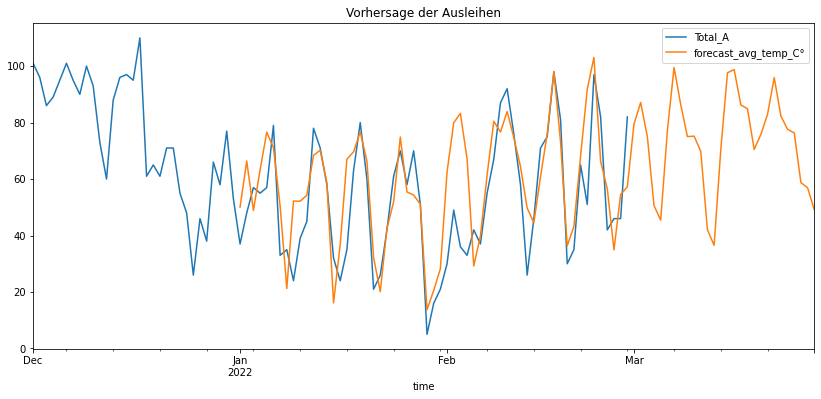

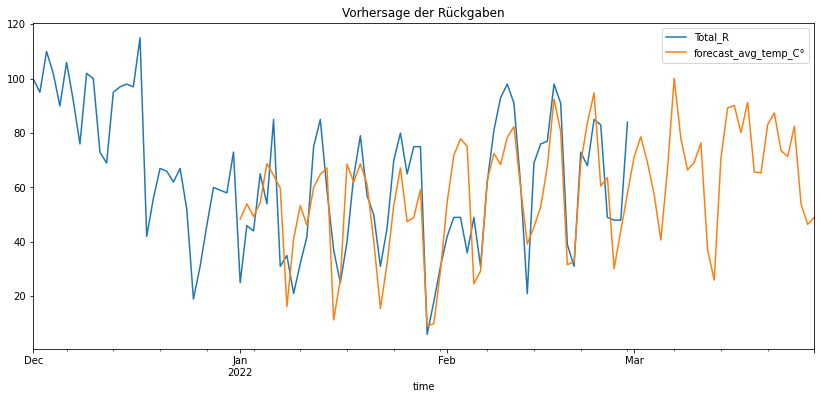

In [43]:
bike_arima_AW_new[['Total_A', 'forecast_avg_temp_C°']].plot(figsize=(14,6), title='Vorhersage der Ausleihen')
bike_arima_RW_new[['Total_R', 'forecast_avg_temp_C°']].plot(figsize=(14,6), title='Vorhersage der Rückgaben')

<AxesSubplot:title={'center':'Vorhersage der Rückgaben'}, xlabel='time'>

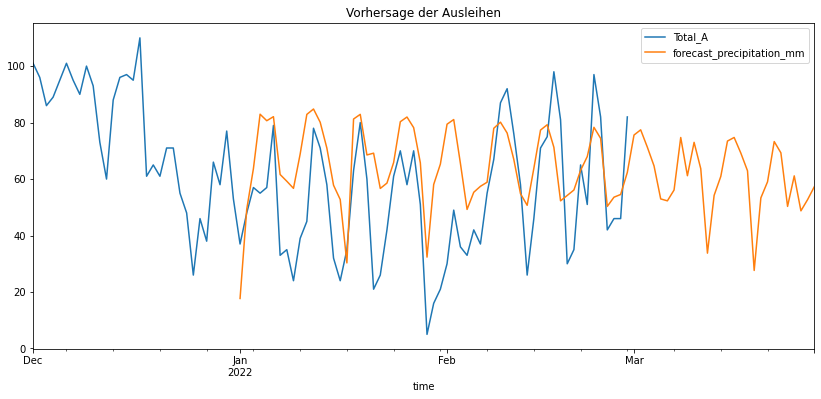

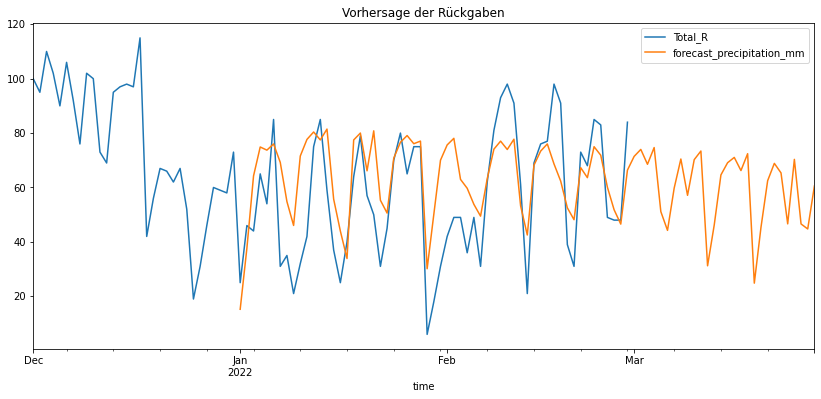

In [44]:
bike_arima_AW_new[['Total_A', 'forecast_precipitation_mm']].plot(figsize=(14,6), title='Vorhersage der Ausleihen')
bike_arima_RW_new[['Total_R', 'forecast_precipitation_mm']].plot(figsize=(14,6), title='Vorhersage der Rückgaben')

<AxesSubplot:title={'center':'Vorhersage der Rückgaben'}, xlabel='time'>

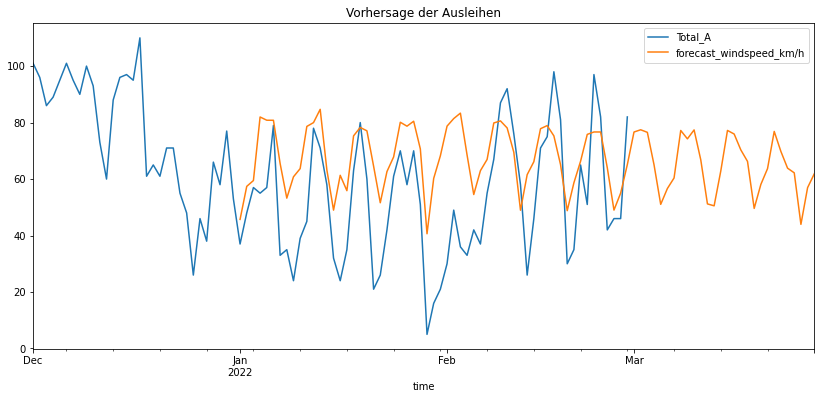

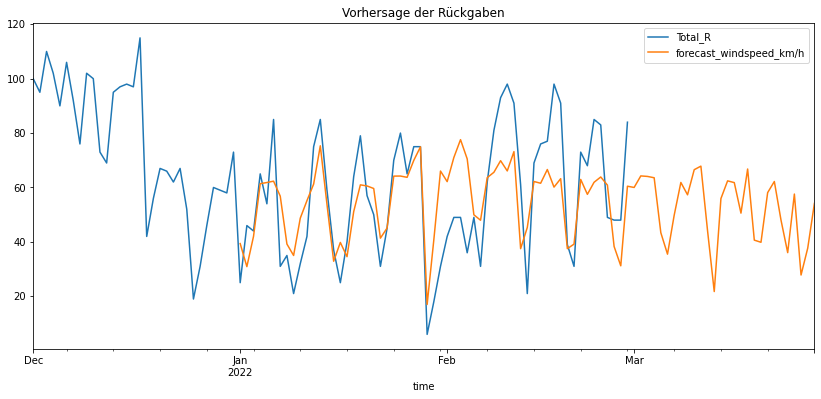

In [45]:
bike_arima_AW_new[['Total_A', 'forecast_windspeed_km/h']].plot(figsize=(14,6), title='Vorhersage der Ausleihen')
bike_arima_RW_new[['Total_R', 'forecast_windspeed_km/h']].plot(figsize=(14,6), title='Vorhersage der Rückgaben')

---Prognose über die historischen Daten

In [46]:
train_prediction_A_ex1 = model_result_train_A_ex1.predict(start = len(train_arima_A), end = len(bike_arima_AW)-1, exog=test_arima_A['avg_temp_C°']).rename('Test_ARIMA_Predictions_A_ex1')###---predict von Ende train_arima_A bis Ende test_arima_A = testdaten
train_prediction_R_ex1 = model_result_train_R_ex1.predict(start = len(train_arima_R), end = len(bike_arima_RW)-1, exog=test_arima_R['avg_temp_C°']).rename('Test_ARIMA_Predictions_R_ex1')###---predict von Ende train_arima_R bis Ende test_arima_R = testdaten

train_prediction_A_ex2 = model_result_train_A_ex2.predict(start = len(train_arima_A), end = len(bike_arima_AW)-1, exog=test_arima_A['precipitation_mm']).rename('Test_ARIMA_Predictions_A_ex2') 
train_prediction_R_ex2 = model_result_train_R_ex2.predict(start = len(train_arima_R), end = len(bike_arima_RW)-1, exog=test_arima_R['precipitation_mm']).rename('Test_ARIMA_Predictions_R_ex2') 

train_prediction_A_ex3 = model_result_train_A_ex3.predict(start = len(train_arima_A), end = len(bike_arima_AW)-1, exog=test_arima_A['windspeed_km/h']).rename('Test_ARIMA_Predictions_A_ex3') 
train_prediction_R_ex3 = model_result_train_R_ex3.predict(start = len(train_arima_R), end = len(bike_arima_RW)-1, exog=test_arima_R['windspeed_km/h']).rename('Test_ARIMA_Predictions_R_ex3')

---Grafiken ohne Zukunftswerte

--Ausleihen

<AxesSubplot:xlabel='time'>

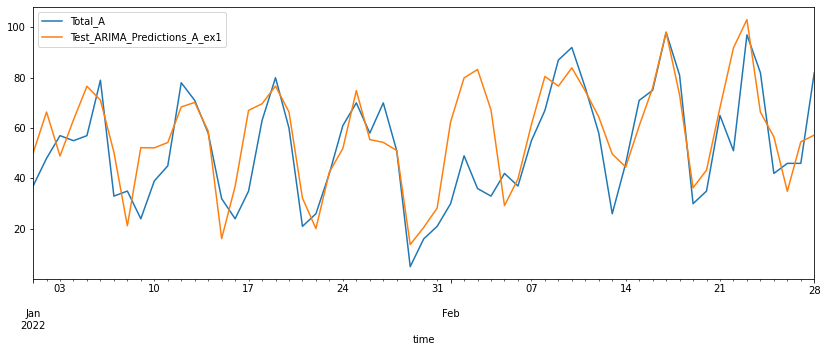

In [47]:
test_arima_A['Total_A'].plot(figsize=(14,5), legend=True)
train_prediction_A_ex1.plot(legend=True)

<AxesSubplot:xlabel='time'>

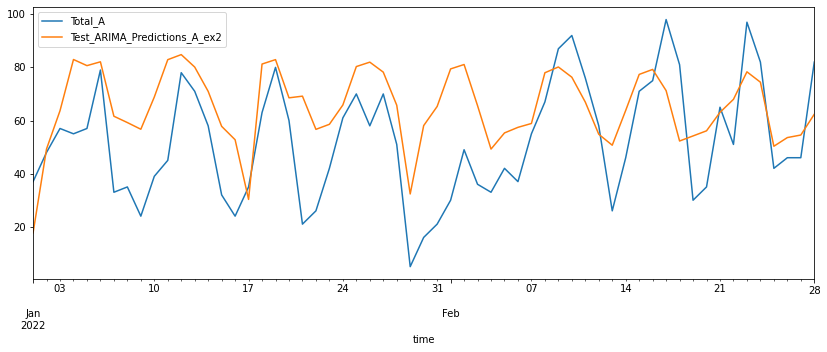

In [48]:
test_arima_A['Total_A'].plot(figsize=(14,5), legend=True)
train_prediction_A_ex2.plot(legend=True)

<AxesSubplot:xlabel='time'>

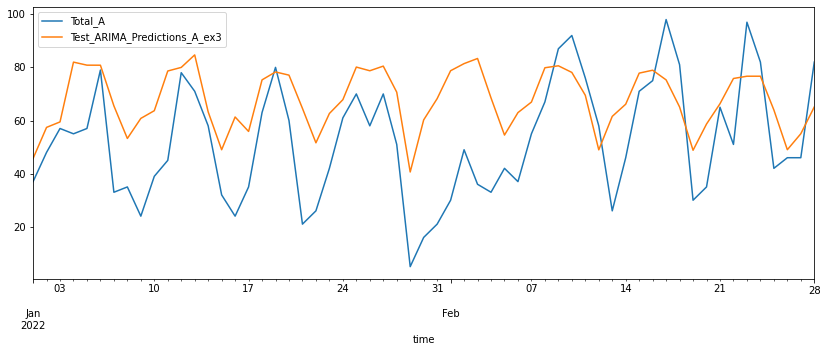

In [49]:
test_arima_A['Total_A'].plot(figsize=(14,5), legend=True)
train_prediction_A_ex3.plot(legend=True)

--Rückgaben

<AxesSubplot:xlabel='time'>

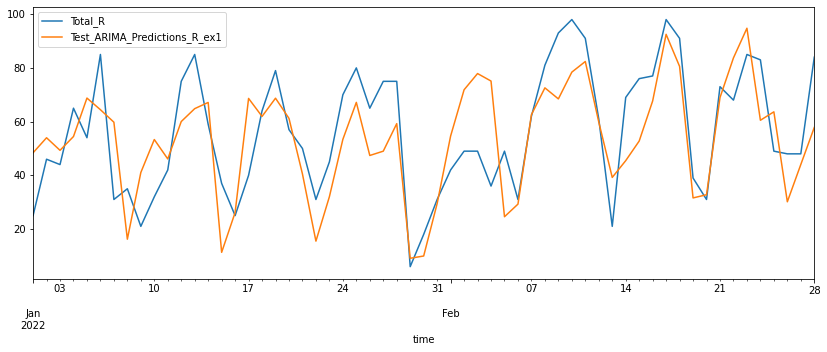

In [50]:
test_arima_R['Total_R'].plot(figsize=(14,5), legend=True)
train_prediction_R_ex1.plot(legend=True)

<AxesSubplot:xlabel='time'>

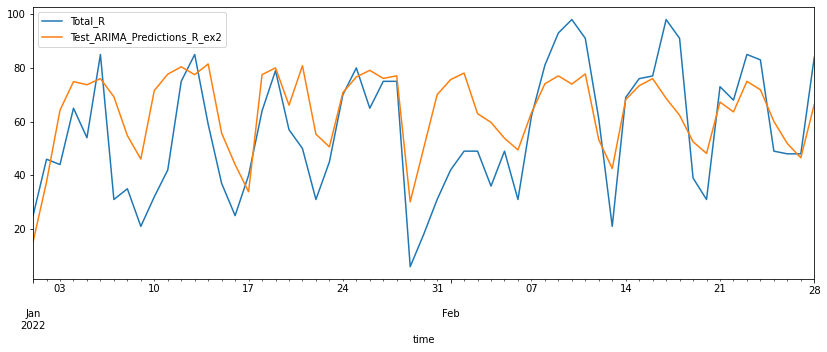

In [51]:
test_arima_R['Total_R'].plot(figsize=(14,5), legend=True)
train_prediction_R_ex2.plot(legend=True)

<AxesSubplot:xlabel='time'>

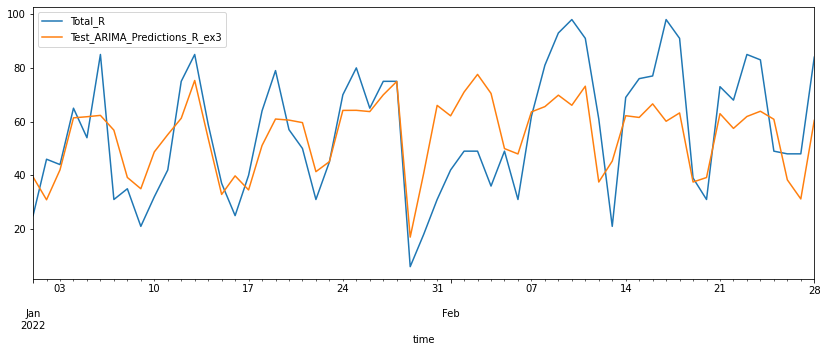

In [52]:
test_arima_R['Total_R'].plot(figsize=(14,5), legend=True)
train_prediction_R_ex3.plot(legend=True)

---Fehlermaß ermitteln

In [55]:
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error

--Ausleihen

In [56]:
test_arima_rmse_error_A_ex1 = rmse(test_arima_A['Total_A'], train_prediction_A_ex1)
test_arima_mse_error_A_ex1 = test_arima_rmse_error_A_ex1**2
test_arima_mape_error_A_ex1 = mean_absolute_error(test_arima_A['Total_A'], train_prediction_A_ex1)
test_mean_value_A_ex1 = bike_arima_AW['Total_A'].mean()

print(f'RMSE Error: {test_arima_rmse_error_A_ex1}\nMSE Error: {test_arima_mse_error_A_ex1}\nMAPE Error: {test_arima_mape_error_A_ex1}\nMean: {test_mean_value_A_ex1}')

RMSE Error: 15.83028424625471
MSE Error: 250.59789931722005
MAPE Error: 11.967859607955049
Mean: 94.2296052631579


In [55]:
test_arima_rmse_error_A_ex2 = rmse(test_arima_A['Total_A'], train_prediction_A_ex2)
test_arima_mse_error_A_ex2 = test_arima_rmse_error_A_ex2**2
test_arima_mape_error_A_ex2 = mean_absolute_error(test_arima_A['Total_A'], train_prediction_A_ex2)
test_mean_value_A_ex2 = bike_arima_AW['Total_A'].mean()

print(f'RMSE Error: {test_arima_rmse_error_A_ex2}\nMSE Error: {test_arima_mse_error_A_ex2}\nMAPE Error: {test_arima_mape_error_A_ex2}\nMean: {test_mean_value_A_ex2}')

RMSE Error: 21.93023944579697
MSE Error: 480.93540214998944
MAPE Error: 18.275742868958456
Mean: 94.2296052631579


In [56]:
test_arima_rmse_error_A_ex3 = rmse(test_arima_A['Total_A'], train_prediction_A_ex3)
test_arima_mse_error_A_ex3 = test_arima_rmse_error_A_ex3**2
test_arima_mape_error_A_ex3 = mean_absolute_error(test_arima_A['Total_A'], train_prediction_A_ex3)
test_mean_value_A_ex3 = bike_arima_AW['Total_A'].mean()

print(f'RMSE Error: {test_arima_rmse_error_A_ex3}\nMSE Error: {test_arima_mse_error_A_ex3}\nMAPE Error: {test_arima_mape_error_A_ex3}\nMean: {test_mean_value_A_ex3}')

RMSE Error: 23.293066536964087
MSE Error: 542.5669486954362
MAPE Error: 19.398838314070154
Mean: 94.2296052631579


In [57]:
rmse_arima_A = pd.DataFrame({"Wetterart" : ["Durchschnittstemperatur", "Niederschlagsmenge", "Windgeschwindigkeit"], "RMSE der Ausleihen in ARIMA" : (test_arima_rmse_error_A_ex1, test_arima_rmse_error_A_ex2, test_arima_rmse_error_A_ex3)})
rmse_arima_A

Wetterart  RMSE der Ausleihen in ARIMA
0  Durchschnittstemperatur                    15.830284
1       Niederschlagsmenge                    21.930239
2      Windgeschwindigkeit                    23.293067

--Rückgaben

In [58]:
test_arima_rmse_error_R_ex1 = rmse(test_arima_R['Total_R'], train_prediction_R_ex1)
test_arima_mse_error_R_ex1 = test_arima_rmse_error_R_ex1**2
test_arima_mape_error_R_ex1 = mean_absolute_error(test_arima_R['Total_R'], train_prediction_R_ex1)
test_mean_value_R_ex1 = bike_arima_RW['Total_R'].mean()

print(f'RMSE Error: {test_arima_rmse_error_R_ex1}\nMSE Error: {test_arima_mse_error_R_ex1}\nMAPE Error: {test_arima_mape_error_R_ex1}\nMean: {test_mean_value_R_ex1}')

RMSE Error: 16.768384328228
MSE Error: 281.17871297916236
MAPE Error: 14.186936459420197
Mean: 111.71052631578948


In [59]:
test_arima_rmse_error_R_ex2 = rmse(test_arima_R['Total_R'], train_prediction_R_ex2)
test_arima_mse_error_R_ex2 = test_arima_rmse_error_R_ex2**2
test_arima_mape_error_R_ex2 = mean_absolute_error(test_arima_R['Total_R'], train_prediction_R_ex2)
test_mean_value_R_ex2 = bike_arima_RW['Total_R'].mean()

print(f'RMSE Error: {test_arima_rmse_error_R_ex2}\nMSE Error: {test_arima_mse_error_R_ex2}\nMAPE Error: {test_arima_mape_error_R_ex2}\nMean: {test_mean_value_R_ex2}')

RMSE Error: 18.671494532438693
MSE Error: 348.624708074888
MAPE Error: 15.056784240787493
Mean: 111.71052631578948


In [60]:
test_arima_rmse_error_R_ex3 = rmse(test_arima_R['Total_R'], train_prediction_R_ex3)
test_arima_mse_error_R_ex3 = test_arima_rmse_error_R_ex3**2
test_arima_mape_error_R_ex3 = mean_absolute_error(test_arima_R['Total_R'], train_prediction_R_ex3)
test_mean_value_R_ex3 = bike_arima_RW['Total_R'].mean()

print(f'RMSE Error: {test_arima_rmse_error_R_ex3}\nMSE Error: {test_arima_mse_error_R_ex3}\nMAPE Error: {test_arima_mape_error_R_ex3}\nMean: {test_mean_value_R_ex3}')

RMSE Error: 17.01175127465477
MSE Error: 289.3996814307182
MAPE Error: 14.173577787344271
Mean: 111.71052631578948


In [61]:
rmse_arima_R = pd.DataFrame({"Wetterart" : ["Durchschnittstemperatur", "Niederschlagsmenge", "Windgeschwindigkeit"], "RMSE der Rückgaben in ARIMA" : (test_arima_rmse_error_R_ex1, test_arima_rmse_error_R_ex2, test_arima_rmse_error_R_ex3)})
rmse_arima_R

Wetterart  RMSE der Rückgaben in ARIMA
0  Durchschnittstemperatur                    16.768384
1       Niederschlagsmenge                    18.671495
2      Windgeschwindigkeit                    17.011751

In [62]:
test_arima_A
#test_arima_R

Total_A  avg_temp_C°  precipitation_mm  windspeed_km/h
time                                                              
2022-01-01       37          9.7              24.0             7.8
2022-01-02       48          9.1               5.2            15.7
2022-01-03       57         -1.9               2.5            22.7
2022-01-04       55         -2.8               0.0            11.1
2022-01-05       57          3.0               3.3            13.3
2022-01-06       79          1.5               0.0            14.7
2022-01-07       33         -1.2               8.1            20.5
2022-01-08       35         -6.0               0.0            12.0
2022-01-09       24          1.5               3.2            17.6
2022-01-10       39         -2.1               0.0            20.6
2022-01-11       45         -7.2               0.0            18.1
2022-01-12       78         -1.2               0.0            16.1
2022-01-13       71          1.1               0.0             7.3
2022-01-14       58          1.3               0.0            24.2
2022-01-15       32         -8.2               0.0            18.2
2022-01-16       24         -4.4               5.1            15.6
2022-01-17       35          3.8              27.1            31.6
2022-01-18       63         -1.0               0.0            21.7
2022-01-19       80          2.3               0.0            16.8
2022-01-20       60         -0.1               7.8            18.1
2022-01-21       21         -8.7               0.0            20.2
2022-01-22       26         -6.5               0.0            12.6
2022-01-23       42         -2.0               0.1            12.1
2022-01-24       61         -1.8               0.1            10.5
2022-01-25       70          1.3               0.0            12.2
2022-01-26       58         -5.6               0.0            14.5
2022-01-27       70         -4.5               0.0            11.0
2022-01-28       51         -1.2               2.0             8.8
2022-01-29        5         -8.8              17.6            29.7
2022-01-30       16        -10.3               0.0            14.9
2022-01-31       21        -10.7               0.0             8.6
2022-02-01       30         -3.2               0.0            13.0
2022-02-02       49          4.1               0.0             8.6
2022-02-03       36          6.9               8.7             4.8
2022-02-04       33          5.2              13.7            11.1
2022-02-05       42         -2.7               0.1             5.8
2022-02-06       37         -2.7               0.0             9.2
2022-02-07       55          2.3               4.2             9.5
2022-02-08       67          4.0               0.4             9.7
2022-02-09       87          3.1               0.0             8.5
2022-02-10       92          7.4               0.1            12.0
2022-02-11       76          8.3               0.0             8.2
2022-02-12       58         11.0               0.0            14.0
2022-02-13       26          1.3               4.5            10.4
2022-02-14       46         -4.0               0.0             9.6
2022-02-15       71         -3.3               0.2            11.6
2022-02-16       75          3.1               0.0             9.8
2022-02-17       98         13.1               3.2            15.2
2022-02-18       81          7.9              10.3            14.2
2022-02-19       30          0.3               0.0            13.3
2022-02-20       35         -1.0               0.0            14.0
2022-02-21       65          5.3               0.0             8.1
2022-02-22       51          8.9               6.5            13.5
2022-02-23       97         13.8               0.0            12.1
2022-02-24       82          1.1               0.2            11.5
2022-02-25       42          1.7              11.2            14.8
2022-02-26       46         -0.1               0.0            12.0
2022-02-27       46          3.5               0.7         

In [63]:
test_arima_A['Test_ARIMA_Predictions_A_temp'] = train_prediction_A_ex1
test_arima_R['Test_ARIMA_Predictions_R_temp'] = train_prediction_R_ex1

test_arima_A['Test_ARIMA_Predictions_A_preci'] = train_prediction_A_ex2
test_arima_R['Test_ARIMA_Predictions_R_preci'] = train_prediction_R_ex2

test_arima_A['Test_ARIMA_Predictions_A_wind'] = train_prediction_A_ex3
test_arima_R['Test_ARIMA_Predictions_R_wind'] = train_prediction_R_ex3

c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [64]:
test_arima_A

Total_A  avg_temp_C°  precipitation_mm  windspeed_km/h  \
time                                                                 
2022-01-01       37          9.7              24.0             7.8   
2022-01-02       48          9.1               5.2            15.7   
2022-01-03       57         -1.9               2.5            22.7   
2022-01-04       55         -2.8               0.0            11.1   
2022-01-05       57          3.0               3.3            13.3   
2022-01-06       79          1.5               0.0            14.7   
2022-01-07       33         -1.2               8.1            20.5   
2022-01-08       35         -6.0               0.0            12.0   
2022-01-09       24          1.5               3.2            17.6   
2022-01-10       39         -2.1               0.0            20.6   
2022-01-11       45         -7.2               0.0            18.1   
2022-01-12       78         -1.2               0.0            16.1   
2022-01-13       71          1.1               0.0             7.3   
2022-01-14       58          1.3               0.0            24.2   
2022-01-15       32         -8.2               0.0            18.2   
2022-01-16       24         -4.4               5.1            15.6   
2022-01-17       35          3.8              27.1            31.6   
2022-01-18       63         -1.0               0.0            21.7   
2022-01-19       80          2.3               0.0            16.8   
2022-01-20       60         -0.1               7.8            18.1   
2022-01-21       21         -8.7               0.0            20.2   
2022-01-22       26         -6.5               0.0            12.6   
2022-01-23       42         -2.0               0.1            12.1   
2022-01-24       61         -1.8               0.1            10.5   
2022-01-25       70          1.3               0.0            12.2   
2022-01-26       58         -5.6               0.0            14.5   
2022-01-27       70         -4.5               0.0            11.0   
2022-01-28       51         -1.2               2.0             8.8   
2022-01-29        5         -8.8              17.6            29.7   
2022-01-30       16        -10.3               0.0            14.9   
2022-01-31       21        -10.7               0.0             8.6   
2022-02-01       30         -3.2               0.0            13.0   
2022-02-02       49          4.1               0.0             8.6   
2022-02-03       36          6.9               8.7             4.8   
2022-02-04       33          5.2              13.7            11.1   
2022-02-05       42         -2.7               0.1             5.8   
2022-02-06       37         -2.7               0.0             9.2   
2022-02-07       55          2.3               4.2             9.5   
2022-02-08       67          4.0               0.4             9.7   
2022-02-09       87          3.1               0.0             8.5   
2022-02-10       92          7.4               0.1            12.0   
2022-02-11       76          8.3               0.0             8.2   
2022-02-12       58         11.0               0.0            14.0   
2022-02-13       26          1.3               4.5            10.4   
2022-02-14       46         -4.0               0.0             9.6   
2022-02-15       71         -3.3               0.2            11.6   
2022-02-16       75          3.1               0.0             9.8   
2022-02-17       98         13.1               3.2            15.2   
2022-02-18       81          7.9              10.3            14.2   
2022-02-19       30          0.3               0.0            13.3   
2022-02-20       35         -1.0               0.0            14.0   
2022-02-21       65          5.3               0.0             8.1   
2022-02-22       51          8.9               6.5            13.5   
2022-02-23       97         13.8               0.0            12.1   
2022-02-24       82          1.1               0.2            11.5   
2022-02-25       42   

---Differenzen bilden zwischen Ausleihen & Rückgaben

In [65]:
test_arima_AR = pd.merge(test_arima_A, test_arima_R, on=('time', 'avg_temp_C°', 'precipitation_mm', 'windspeed_km/h'))

In [66]:
test_arima_AR['diff_Total'] = (test_arima_AR['Total_A'] - test_arima_AR['Total_R'])

test_arima_AR['diff_temp'] = (test_arima_AR['Test_ARIMA_Predictions_A_temp'] - test_arima_AR['Test_ARIMA_Predictions_R_temp'])
test_arima_AR['diff_preci'] = (test_arima_AR['Test_ARIMA_Predictions_A_preci'] - test_arima_AR['Test_ARIMA_Predictions_R_preci'])
test_arima_AR['diff_wind'] = (test_arima_AR['Test_ARIMA_Predictions_A_wind'] - test_arima_AR['Test_ARIMA_Predictions_R_wind'])

In [67]:
test_arima_AR['MAPE_temp'] = mean_absolute_error(test_arima_AR['diff_Total'], test_arima_AR['diff_temp'])
test_arima_AR['MAPE_preci'] = mean_absolute_error(test_arima_AR['diff_Total'], test_arima_AR['diff_preci'])
test_arima_AR['MAPE_wind'] = mean_absolute_error(test_arima_AR['diff_Total'], test_arima_AR['diff_wind'])

In [68]:
mape_diff_arima_AR = pd.DataFrame(index=['MAPE_value'])
mape_diff_arima_AR['temp'] = mean_absolute_error(test_arima_AR['diff_Total'], test_arima_AR['diff_temp'])
mape_diff_arima_AR['preci'] = mean_absolute_error(test_arima_AR['diff_Total'], test_arima_AR['diff_preci'])
mape_diff_arima_AR['wind'] = mean_absolute_error(test_arima_AR['diff_Total'], test_arima_AR['diff_wind'])

In [69]:
mape_diff_arima_AR

temp     preci      wind
MAPE_value  10.153757  7.840743  17.11508

In [70]:
test_arima_AR

Total_A  avg_temp_C°  precipitation_mm  windspeed_km/h  \
time                                                                 
2022-01-01       37          9.7              24.0             7.8   
2022-01-02       48          9.1               5.2            15.7   
2022-01-03       57         -1.9               2.5            22.7   
2022-01-04       55         -2.8               0.0            11.1   
2022-01-05       57          3.0               3.3            13.3   
2022-01-06       79          1.5               0.0            14.7   
2022-01-07       33         -1.2               8.1            20.5   
2022-01-08       35         -6.0               0.0            12.0   
2022-01-09       24          1.5               3.2            17.6   
2022-01-10       39         -2.1               0.0            20.6   
2022-01-11       45         -7.2               0.0            18.1   
2022-01-12       78         -1.2               0.0            16.1   
2022-01-13       71          1.1               0.0             7.3   
2022-01-14       58          1.3               0.0            24.2   
2022-01-15       32         -8.2               0.0            18.2   
2022-01-16       24         -4.4               5.1            15.6   
2022-01-17       35          3.8              27.1            31.6   
2022-01-18       63         -1.0               0.0            21.7   
2022-01-19       80          2.3               0.0            16.8   
2022-01-20       60         -0.1               7.8            18.1   
2022-01-21       21         -8.7               0.0            20.2   
2022-01-22       26         -6.5               0.0            12.6   
2022-01-23       42         -2.0               0.1            12.1   
2022-01-24       61         -1.8               0.1            10.5   
2022-01-25       70          1.3               0.0            12.2   
2022-01-26       58         -5.6               0.0            14.5   
2022-01-27       70         -4.5               0.0            11.0   
2022-01-28       51         -1.2               2.0             8.8   
2022-01-29        5         -8.8              17.6            29.7   
2022-01-30       16        -10.3               0.0            14.9   
2022-01-31       21        -10.7               0.0             8.6   
2022-02-01       30         -3.2               0.0            13.0   
2022-02-02       49          4.1               0.0             8.6   
2022-02-03       36          6.9               8.7             4.8   
2022-02-04       33          5.2              13.7            11.1   
2022-02-05       42         -2.7               0.1             5.8   
2022-02-06       37         -2.7               0.0             9.2   
2022-02-07       55          2.3               4.2             9.5   
2022-02-08       67          4.0               0.4             9.7   
2022-02-09       87          3.1               0.0             8.5   
2022-02-10       92          7.4               0.1            12.0   
2022-02-11       76          8.3               0.0             8.2   
2022-02-12       58         11.0               0.0            14.0   
2022-02-13       26          1.3               4.5            10.4   
2022-02-14       46         -4.0               0.0             9.6   
2022-02-15       71         -3.3               0.2            11.6   
2022-02-16       75          3.1               0.0             9.8   
2022-02-17       98         13.1               3.2            15.2   
2022-02-18       81          7.9              10.3            14.2   
2022-02-19       30          0.3               0.0            13.3   
2022-02-20       35         -1.0               0.0            14.0   
2022-02-21       65          5.3               0.0             8.1   
2022-02-22       51          8.9               6.5            13.5   
2022-02-23       97         13.8               0.0            12.1   
2022-02-24       82          1.1               0.2            11.5   
2022-02-25       42   

-------------------Prophet-------------------

---Durchführung des Prophet-Modells mit train & test Daten für die Zukunftsprognose

In [71]:
bike_prophet_A = data_A.copy()
bike_prophet_A['ds'] = pd.to_datetime(bike_prophet_A.index)
bike_prophet_A['y'] = pd.DataFrame(bike_prophet_A['Total_A'])
bike_prophet_A

Total_A         ds   y
time                              
2018-01-01       13 2018-01-01  13
2018-01-02       61 2018-01-02  61
2018-01-03       51 2018-01-03  51
2018-01-04        3 2018-01-04   3
2018-01-05        9 2018-01-05   9
...             ...        ...  ..
2022-02-24       82 2022-02-24  82
2022-02-25       42 2022-02-25  42
2022-02-26       46 2022-02-26  46
2022-02-27       46 2022-02-27  46
2022-02-28       82 2022-02-28  82

[1520 rows x 3 columns]

In [72]:
bike_prophet_R = data_R.copy()
bike_prophet_R['ds'] = pd.to_datetime(bike_prophet_R.index)
bike_prophet_R['y'] = pd.DataFrame(bike_prophet_R['Total_R'])
bike_prophet_R

Total_R         ds   y
time                              
2018-01-01       12 2018-01-01  12
2018-01-02       60 2018-01-02  60
2018-01-03       81 2018-01-03  81
2018-01-04       11 2018-01-04  11
2018-01-05       17 2018-01-05  17
...             ...        ...  ..
2022-02-24       83 2022-02-24  83
2022-02-25       49 2022-02-25  49
2022-02-26       48 2022-02-26  48
2022-02-27       48 2022-02-27  48
2022-02-28       84 2022-02-28  84

[1520 rows x 3 columns]

In [73]:
bike_prophet_AW = pd.merge(bike_prophet_A, weather, on='time', how='left')
bike_prophet_RW = pd.merge(bike_prophet_R, weather, on='time', how='left')

In [74]:
bike_prophet_AW_new = bike_prophet_AW.copy()
bike_prophet_RW_new = bike_prophet_RW.copy()

In [75]:
future_dates_prophet_AW = [bike_prophet_AW_new.index[-60] + DateOffset(days = x) for x in range(0,88)]
future_dates_prophet_RW = [bike_prophet_RW_new.index[-60] + DateOffset(days = x) for x in range(0,88)]

In [76]:
future_dates_prophet_AW
future_dates_prophet_RW

[Timestamp('2021-12-31 00:00:00'),
 Timestamp('2022-01-01 00:00:00'),
 Timestamp('2022-01-02 00:00:00'),
 Timestamp('2022-01-03 00:00:00'),
 Timestamp('2022-01-04 00:00:00'),
 Timestamp('2022-01-05 00:00:00'),
 Timestamp('2022-01-06 00:00:00'),
 Timestamp('2022-01-07 00:00:00'),
 Timestamp('2022-01-08 00:00:00'),
 Timestamp('2022-01-09 00:00:00'),
 Timestamp('2022-01-10 00:00:00'),
 Timestamp('2022-01-11 00:00:00'),
 Timestamp('2022-01-12 00:00:00'),
 Timestamp('2022-01-13 00:00:00'),
 Timestamp('2022-01-14 00:00:00'),
 Timestamp('2022-01-15 00:00:00'),
 Timestamp('2022-01-16 00:00:00'),
 Timestamp('2022-01-17 00:00:00'),
 Timestamp('2022-01-18 00:00:00'),
 Timestamp('2022-01-19 00:00:00'),
 Timestamp('2022-01-20 00:00:00'),
 Timestamp('2022-01-21 00:00:00'),
 Timestamp('2022-01-22 00:00:00'),
 Timestamp('2022-01-23 00:00:00'),
 Timestamp('2022-01-24 00:00:00'),
 Timestamp('2022-01-25 00:00:00'),
 Timestamp('2022-01-26 00:00:00'),
 Timestamp('2022-01-27 00:00:00'),
 Timestamp('2022-01-

In [77]:
future_date_prophet_df_AW = pd.DataFrame(index = future_dates_prophet_AW[1:], columns = bike_prophet_AW_new.columns)
future_date_prophet_df_RW = pd.DataFrame(index = future_dates_prophet_RW[1:], columns = bike_prophet_RW_new.columns)

In [78]:
bike_prophet_AW_new = pd.concat([bike_prophet_AW_new, future_date_prophet_df_AW[-87:]])
bike_prophet_RW_new = pd.concat([bike_prophet_RW_new, future_date_prophet_df_RW[-87:]])

In [79]:
bike_prophet_AW_new
bike_prophet_RW_new

Total_R         ds    y  avg_temp_C°  precipitation_mm  \
2018-01-01      12 2018-01-01   12         -8.6               0.0   
2018-01-02      60 2018-01-02   60         -6.0               0.0   
2018-01-03      81 2018-01-03   81         -4.0               0.0   
2018-01-04      11 2018-01-04   11         -2.9              18.0   
2018-01-05      17 2018-01-05   17         -8.1               0.0   
...            ...        ...  ...          ...               ...   
2022-03-24     NaN        NaT  NaN          NaN               NaN   
2022-03-25     NaN        NaT  NaN          NaN               NaN   
2022-03-26     NaN        NaT  NaN          NaN               NaN   
2022-03-27     NaN        NaT  NaN          NaN               NaN   
2022-03-28     NaN        NaT  NaN          NaN               NaN   

            windspeed_km/h  
2018-01-01             9.6  
2018-01-02            19.9  
2018-01-03            13.0  
2018-01-04            10.5  
2018-01-05             9.1  
...                    ...  
2022-03-24             NaN  
2022-03-25             NaN  
2022-03-26             NaN  
2022-03-27             NaN  
2022-03-28             NaN  

[1607 rows x 6 columns]

In [80]:
bike_prophet_AW_new = bike_prophet_AW_new[~bike_prophet_AW_new.index.duplicated(keep='first')]
bike_prophet_AW_new.index.name = 'time'
bike_prophet_RW_new = bike_prophet_RW_new[~bike_prophet_RW_new.index.duplicated(keep='first')]
bike_prophet_RW_new.index.name = 'time'

In [81]:
cols_to_use_prophet_AW = bike_prophet_AW_new.columns.difference(weather.columns)
cols_to_use_prophet_RW = bike_prophet_RW_new.columns.difference(weather.columns)

In [82]:
bike_prophet_AW_new = pd.merge(bike_prophet_AW_new[cols_to_use_prophet_AW], weather, on='time')
bike_prophet_RW_new = pd.merge(bike_prophet_RW_new[cols_to_use_prophet_RW], weather, on='time')

In [83]:
bike_prophet_AW_new
bike_prophet_RW_new

Total_R         ds    y  avg_temp_C°  precipitation_mm  \
time                                                                
2018-01-01      12 2018-01-01   12         -8.6               0.0   
2018-01-02      60 2018-01-02   60         -6.0               0.0   
2018-01-03      81 2018-01-03   81         -4.0               0.0   
2018-01-04      11 2018-01-04   11         -2.9              18.0   
2018-01-05      17 2018-01-05   17         -8.1               0.0   
...            ...        ...  ...          ...               ...   
2022-03-24     NaN        NaT  NaN          6.4              15.6   
2022-03-25     NaN        NaT  NaN         10.1               1.0   
2022-03-26     NaN        NaT  NaN          9.6               1.8   
2022-03-27     NaN        NaT  NaN          5.1               0.2   
2022-03-28     NaN        NaT  NaN         -1.0               1.7   

            windspeed_km/h  
time                        
2018-01-01             9.6  
2018-01-02            19.9  
2018-01-03            13.0  
2018-01-04            10.5  
2018-01-05             9.1  
...                    ...  
2022-03-24            27.1  
2022-03-25            12.9  
2022-03-26            16.6  
2022-03-27            11.3  
2022-03-28             9.6  

[1548 rows x 6 columns]

In [84]:
bike_prophet_AW_new['ds'] = bike_prophet_AW_new.index.values
bike_prophet_RW_new['ds'] = bike_prophet_RW_new.index.values

In [85]:
bike_prophet_AW_new
bike_prophet_RW_new

Total_R         ds    y  avg_temp_C°  precipitation_mm  \
time                                                                
2018-01-01      12 2018-01-01   12         -8.6               0.0   
2018-01-02      60 2018-01-02   60         -6.0               0.0   
2018-01-03      81 2018-01-03   81         -4.0               0.0   
2018-01-04      11 2018-01-04   11         -2.9              18.0   
2018-01-05      17 2018-01-05   17         -8.1               0.0   
...            ...        ...  ...          ...               ...   
2022-03-24     NaN 2022-03-24  NaN          6.4              15.6   
2022-03-25     NaN 2022-03-25  NaN         10.1               1.0   
2022-03-26     NaN 2022-03-26  NaN          9.6               1.8   
2022-03-27     NaN 2022-03-27  NaN          5.1               0.2   
2022-03-28     NaN 2022-03-28  NaN         -1.0               1.7   

            windspeed_km/h  
time                        
2018-01-01             9.6  
2018-01-02            19.9  
2018-01-03            13.0  
2018-01-04            10.5  
2018-01-05             9.1  
...                    ...  
2022-03-24            27.1  
2022-03-25            12.9  
2022-03-26            16.6  
2022-03-27            11.3  
2022-03-28             9.6  

[1548 rows x 6 columns]

In [86]:
history_prophet_A = bike_prophet_AW_new[:1461]
future_prophet_A = bike_prophet_AW_new[-87:]

history_prophet_R = bike_prophet_RW_new[:1461]
future_prophet_R = bike_prophet_RW_new[-87:]

---Prognose mit den exog Variablen

--Ausleihen

In [87]:
from fbprophet import Prophet

In [88]:
m_train_A_ex1 = Prophet()
m_train_A_ex1.add_regressor('avg_temp_C°')
m_train_A_ex1.fit(history_prophet_A)
future_train_A_ex1 = m_train_A_ex1.make_future_dataframe(periods=0,freq='D')
prophet_pred_train_A_ex1 = m_train_A_ex1.predict(future_prophet_A)
prophet_pred_train_A_ex1

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2022-01-01  101.825982   -0.867495   84.002518   101.825982   101.825982   
1  2022-01-02  101.944876   -4.817555   76.398873   101.944876   101.944876   
2  2022-01-03  102.063771   14.086299   96.178932   102.063771   102.063771   
3  2022-01-04  102.182665   19.226471  105.033267   102.182665   102.182665   
4  2022-01-05  102.301560   31.693448  119.589487   102.301560   102.301560   
..        ...         ...         ...         ...          ...          ...   
82 2022-03-24  111.575325   47.674127  130.062612   109.397681   113.540952   
83 2022-03-25  111.694219   49.315110  131.546505   109.465339   113.716452   
84 2022-03-26  111.813114   11.748635   97.636063   109.536173   113.891952   
85 2022-03-27  111.932008   -4.645249   77.035830   109.613214   114.061604   
86 2022-03-28  112.050902   22.430049  105.478753   109.672598   114.231044   

    additive_terms  additive_terms_lower  additive_terms_upper  avg_temp_C°  \
0       -61.992391            -61.992391            -61.992391    -9.631491   
1       -66.241689            -66.241689            -66.241689   -10.970517   
2       -49.413253            -49.413253            -49.413253   -35.519339   
3       -41.844592            -41.844592            -41.844592   -37.527879   
4       -25.503130            -25.503130            -25.503130   -24.583955   
..             ...                   ...                   ...          ...   
82      -22.755387            -22.755387            -22.755387   -16.996137   
83      -21.340940            -21.340940            -21.340940    -8.738806   
84      -58.520354            -58.520354            -58.520354    -9.854662   
85      -72.920617            -72.920617            -72.920617   -19.897362   
86      -46.869956            -46.869956            -46.869956   -33.510799   

    ...     weekly  weekly_lower  weekly_upper     yearly  yearly_lower  \
0   ... -28.541767    -28.541767    -28.541767 -23.819134    -23.819134   
1   ... -32.531835    -32.531835    -32.531835 -22.739337    -22.739337   
2   ...   7.515697      7.515697      7.515697 -21.409611    -21.409611   
3   ...  15.537954     15.537954     15.537954 -19.854667    -19.854667   
4   ...  17.184981     17.184981     17.184981 -18.104155    -18.104155   
..  ...        ...           ...           ...        ...           ...   
82  ...  13.667015     13.667015     13.667015 -19.426265    -19.426265   
83  ...   7.167955      7.167955      7.167955 -19.770089    -19.770089   
84  ... -28.541767    -28.541767    -28.541767 -20.123925    -20.123925   
85  ... -32.531835    -32.531835    -32.531835 -20.491420    -20.491420   
86  ...   7.515697      7.515697      7.515697 -20.874854    -20.874854   

    yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0     -23.819134                   0.0                         0.0   
1     -22.739337                   0.0                         0.0   
2     -21.409611                   0.0                         0.0   
3     -19.854667                   0.0                         0.0   
4     -18.104155                   0.0                         0.0   
..           ...                   ...                         ...   
82    -19.426265                   0.0                         0.0   
83    -19.770089                   0.0                         0.0   
84    -20.123925                   0.0                         0.0   
85    -20.491420                   0.0                         0.0   
86    -20.874854                   0.0                         0.0   

    multiplicative_terms_upper       yhat  
0                          0.0  39.833591  
1                          0.0  35.703187  
2                          0.0  52.650518  
3                          0.0  60.338074  
4                          0.0  76.798430  
..                         ...        ...  
82                         0.0  88.819937  
83                 

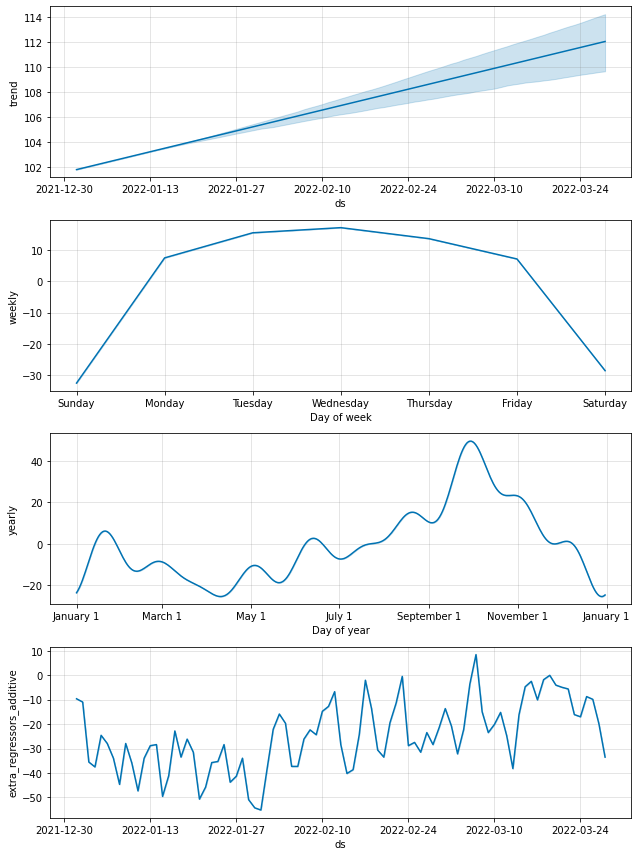

In [89]:
fig1 = m_train_A_ex1.plot_components(prophet_pred_train_A_ex1)

In [90]:
m_train_A_ex2 = Prophet()
m_train_A_ex2.add_regressor('precipitation_mm')
m_train_A_ex2.fit(history_prophet_A)
future_train_A_ex2 = m_train_A_ex2.make_future_dataframe(periods=0,freq='D')
prophet_pred_train_A_ex2 = m_train_A_ex2.predict(future_prophet_A)
prophet_pred_train_A_ex2

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2022-01-01  104.143798  -41.523696   39.668152   104.143798   104.143798   
1  2022-01-02  104.275036  -17.517534   64.132935   104.275036   104.275036   
2  2022-01-03  104.406274   27.745026  109.888668   104.406274   104.406274   
3  2022-01-04  104.537512   39.817807  116.431645   104.537512   104.537512   
4  2022-01-05  104.668750   41.884834  119.768855   104.668750   104.668750   
..        ...         ...         ...         ...          ...          ...   
82 2022-03-24  114.905321   37.565828  121.986570   112.772133   117.268068   
83 2022-03-25  115.036559   50.792451  129.653811   112.864612   117.485407   
84 2022-03-26  115.167797   12.076228   96.124222   112.951501   117.639771   
85 2022-03-27  115.299035   13.526218   92.591058   113.049098   117.855046   
86 2022-03-28  115.430273   52.373401  128.491197   113.139960   118.041107   

    additive_terms  additive_terms_lower  additive_terms_upper  \
0      -104.552715           -104.552715           -104.552715   
1       -81.108211            -81.108211            -81.108211   
2       -35.959250            -35.959250            -35.959250   
3       -23.956580            -23.956580            -23.956580   
4       -24.754704            -24.754704            -24.754704   
..             ...                   ...                   ...   
82      -36.612296            -36.612296            -36.612296   
83      -22.218110            -22.218110            -22.218110   
84      -61.474708            -61.474708            -61.474708   
85      -62.178841            -62.178841            -62.178841   
86      -23.694761            -23.694761            -23.694761   

    extra_regressors_additive  ...     weekly  weekly_lower  weekly_upper  \
0                  -27.716315  ... -29.836988    -29.836988    -29.836988   
1                   -2.070054  ... -32.776783    -32.776783    -32.776783   
2                    1.613186  ...   7.711323      7.711323      7.711323   
3                    5.023593  ...  15.108835     15.108835     15.108835   
4                    0.521855  ...  17.427718     17.427718     17.427718   
..                        ...  ...        ...           ...           ...   
82                 -16.257347  ...  13.976626     13.976626     13.976626   
83                   3.659430  ...   8.389270      8.389270      8.389270   
84                   2.568099  ... -29.836988    -29.836988    -29.836988   
85                   4.750760  ... -32.776783    -32.776783    -32.776783   
86                   2.704516  ...   7.711323      7.711323      7.711323   

       yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0  -46.999412    -46.999412    -46.999412                   0.0   
1  -46.261374    -46.261374    -46.261374                   0.0   
2  -45.283758    -45.283758    -45.283758                   0.0   
3  -44.089007    -44.089007    -44.089007                   0.0   
4  -42.704277    -42.704277    -42.704277                   0.0   
..        ...           ...           ...                   ...   
82 -34.331574    -34.331574    -34.331574                   0.0   
83 -34.266810    -34.266810    -34.266810                   0.0   
84 -34.205820    -34.205820    -34.205820                   0.0   
85 -34.152818    -34.152818    -34.152818                   0.0   
86 -34.110599    -34.110599    -34.110599                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper       yhat  
0                          0.0                         0.0  -0.408917  
1                          0.0                         0.0  23.166825  
2                          0.0                         0.0  68.447024  
3                          0.0                         0.0  80.580932  
4                          0.0                         0.0  79.914046  
..                         ...                         ...        ...  
82                         0.0     

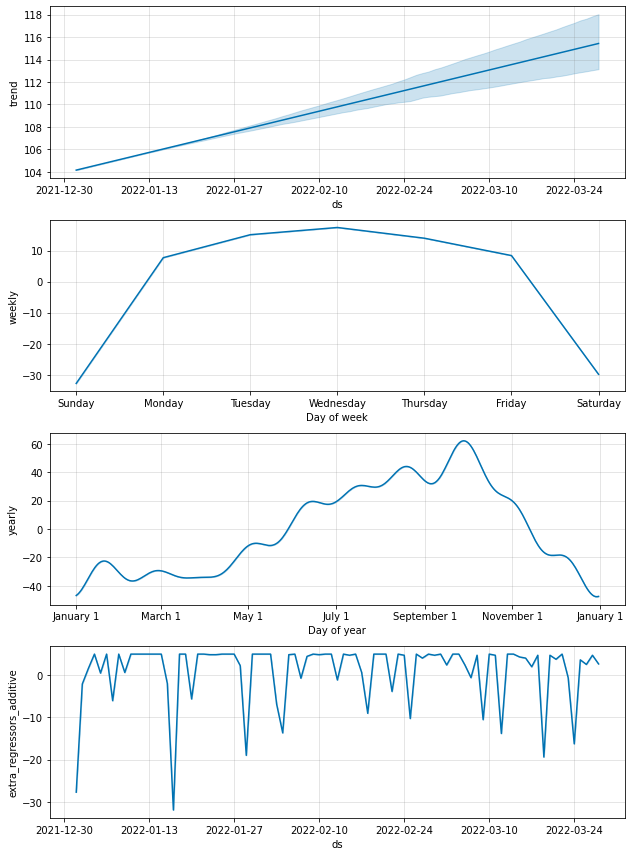

In [91]:
fig2 = m_train_A_ex2.plot_components(prophet_pred_train_A_ex2)

In [92]:
m_train_A_ex3 = Prophet()
m_train_A_ex3.add_regressor('windspeed_km/h')
m_train_A_ex3.fit(history_prophet_A)
future_train_A_ex3 = m_train_A_ex3.make_future_dataframe(periods=0,freq='D')
prophet_pred_train_A_ex3 = m_train_A_ex3.predict(future_prophet_A)
prophet_pred_train_A_ex3

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2022-01-01  102.469345  -12.839325   74.841373   102.469345   102.469345   
1  2022-01-02  102.590422  -21.776207   64.796474   102.590422   102.590422   
2  2022-01-03  102.711499   16.450162  103.875202   102.711499   102.711499   
3  2022-01-04  102.832576   30.111318  116.049707   102.832576   102.832576   
4  2022-01-05  102.953652   34.442595  118.428784   102.953652   102.953652   
..        ...         ...         ...         ...          ...          ...   
82 2022-03-24  112.397647   42.963843  125.857127   110.390736   114.523879   
83 2022-03-25  112.518724   38.898171  126.091541   110.471513   114.718807   
84 2022-03-26  112.639801    3.500854   92.606105   110.552964   114.888966   
85 2022-03-27  112.760878    8.359551   91.977135   110.638639   115.047212   
86 2022-03-28  112.881955   48.617249  132.655692   110.722679   115.212547   

    additive_terms  additive_terms_lower  additive_terms_upper  \
0       -73.657622            -73.657622            -73.657622   
1       -80.825485            -80.825485            -80.825485   
2       -43.467301            -43.467301            -43.467301   
3       -27.808280            -27.808280            -27.808280   
4       -25.593404            -25.593404            -25.593404   
..             ...                   ...                   ...   
82      -27.349557            -27.349557            -27.349557   
83      -25.934497            -25.934497            -25.934497   
84      -64.275009            -64.275009            -64.275009   
85      -64.988868            -64.988868            -64.988868   
86      -23.929720            -23.929720            -23.929720   

    extra_regressors_additive  ...  windspeed_km/h  windspeed_km/h_lower  \
0                    2.148664  ...        2.148664              2.148664   
1                   -2.206127  ...       -2.206127             -2.206127   
2                   -6.064803  ...       -6.064803             -6.064803   
3                    0.329574  ...        0.329574              0.329574   
4                   -0.883153  ...       -0.883153             -0.883153   
..                        ...  ...             ...                   ...   
82                  -8.490256  ...       -8.490256             -8.490256   
83                  -0.662657  ...       -0.662657             -0.662657   
84                  -2.702243  ...       -2.702243             -2.702243   
85                   0.219326  ...        0.219326              0.219326   
86                   1.156433  ...        1.156433              1.156433   

    windspeed_km/h_upper     yearly  yearly_lower  yearly_upper  \
0               2.148664 -46.864532    -46.864532    -46.864532   
1              -2.206127 -46.014280    -46.014280    -46.014280   
2              -6.064803 -44.910395    -44.910395    -44.910395   
3               0.329574 -43.576774    -43.576774    -43.576774   
4              -0.883153 -42.042373    -42.042373    -42.042373   
..                   ...        ...           ...           ...   
82             -8.490256 -32.725409    -32.725409    -32.725409   
83             -0.662657 -32.673626    -32.673626    -32.673626   
84             -2.702243 -32.631012    -32.631012    -32.631012   
85              0.219326 -32.603116    -32.603116    -32.603116   
86              1.156433 -32.594050    -32.594050    -32.594050   

    multiplicative_terms  multiplicative_terms_lower  \
0                    0.0                         0.0   
1                    0.0                         0.0   
2                    0.0                         0.0   
3                    0.0                         0.0   
4                    0.0                         0.0   
..                   ...                         ...   
82                   0.0                         0.0   
83                   0.0                         0.0   
84                   0.0                       

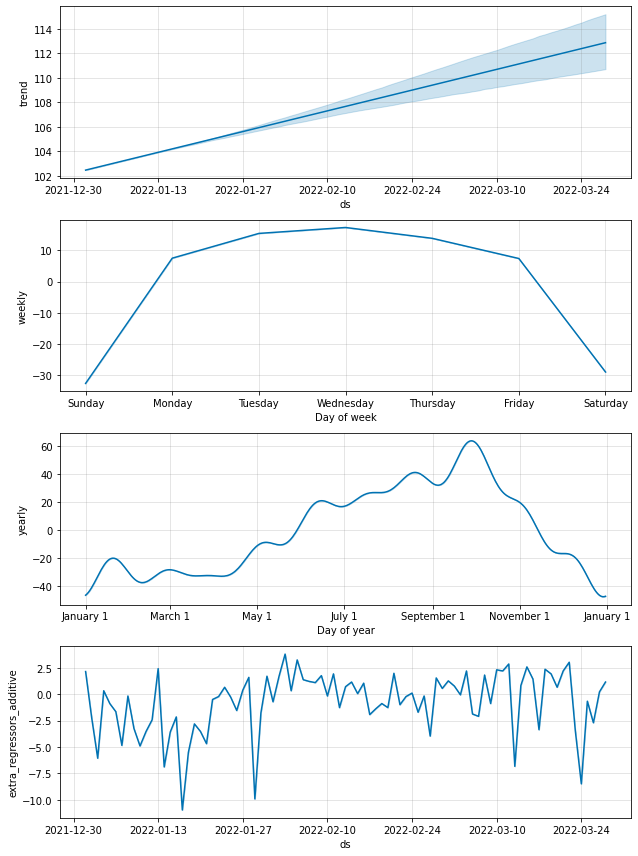

In [93]:
fig3 = m_train_A_ex3.plot_components(prophet_pred_train_A_ex3)

-- Rückgaben

In [94]:
m_train_R_ex1 = Prophet()
m_train_R_ex1.add_regressor('avg_temp_C°')
m_train_R_ex1.fit(history_prophet_R)
future_train_R_ex1 = m_train_R_ex1.make_future_dataframe(periods=0,freq='D')
prophet_pred_train_R_ex1 = m_train_R_ex1.predict(future_prophet_R)
prophet_pred_train_R_ex1

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2022-01-01  100.378365  -28.039769   74.045296   100.378365   100.378365   
1  2022-01-02  100.480625  -42.757628   57.311422   100.480625   100.480625   
2  2022-01-03  100.582885  -12.358701   86.604256   100.582885   100.582885   
3  2022-01-04  100.685145   -5.871526   99.971097   100.685145   100.685145   
4  2022-01-05  100.787405   16.240588  118.445777   100.787405   100.787405   
..        ...         ...         ...         ...          ...          ...   
82 2022-03-24  108.763693   27.529283  130.985515   105.640966   111.513364   
83 2022-03-25  108.865953   34.087720  136.595721   105.680485   111.674920   
84 2022-03-26  108.968214  -14.551805   80.464281   105.693562   111.842564   
85 2022-03-27  109.070474  -41.017018   58.740184   105.729168   112.012296   
86 2022-03-28  109.172734   -3.744969   96.799342   105.774022   112.148761   

    additive_terms  additive_terms_lower  additive_terms_upper  avg_temp_C°  \
0       -77.793393            -77.793393            -77.793393   -11.176059   
1       -91.601308            -91.601308            -91.601308   -12.729820   
2       -66.775101            -66.775101            -66.775101   -41.215449   
3       -51.074759            -51.074759            -51.074759   -43.546092   
4       -33.393335            -33.393335            -33.393335   -28.526396   
..             ...                   ...                   ...          ...   
82      -28.936531            -28.936531            -28.936531   -19.721747   
83      -20.931442            -20.931442            -20.931442   -10.140217   
84      -73.733857            -73.733857            -73.733857   -11.435019   
85      -99.021221            -99.021221            -99.021221   -23.088231   
86      -63.174788            -63.174788            -63.174788   -38.884807   

    ...     weekly  weekly_lower  weekly_upper     yearly  yearly_lower  \
0   ... -34.316334    -34.316334    -34.316334 -32.301000    -32.301000   
1   ... -47.598702    -47.598702    -47.598702 -31.272785    -31.272785   
2   ...   4.400306      4.400306      4.400306 -29.959958    -29.959958   
3   ...  20.864308     20.864308     20.864308 -28.392975    -28.392975   
4   ...  21.740266     21.740266     21.740266 -26.607205    -26.607205   
..  ...        ...           ...           ...        ...           ...   
82  ...  18.068215     18.068215     18.068215 -27.282998    -27.282998   
83  ...  16.841942     16.841942     16.841942 -27.633166    -27.633166   
84  ... -34.316334    -34.316334    -34.316334 -27.982504    -27.982504   
85  ... -47.598702    -47.598702    -47.598702 -28.334288    -28.334288   
86  ...   4.400306      4.400306      4.400306 -28.690287    -28.690287   

    yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0     -32.301000                   0.0                         0.0   
1     -31.272785                   0.0                         0.0   
2     -29.959958                   0.0                         0.0   
3     -28.392975                   0.0                         0.0   
4     -26.607205                   0.0                         0.0   
..           ...                   ...                         ...   
82    -27.282998                   0.0                         0.0   
83    -27.633166                   0.0                         0.0   
84    -27.982504                   0.0                         0.0   
85    -28.334288                   0.0                         0.0   
86    -28.690287                   0.0                         0.0   

    multiplicative_terms_upper       yhat  
0                          0.0  22.584972  
1                          0.0   8.879317  
2                          0.0  33.807783  
3                          0.0  49.610386  
4                          0.0  67.394070  
..                         ...        ...  
82                         0.0  79.827163  
83                 

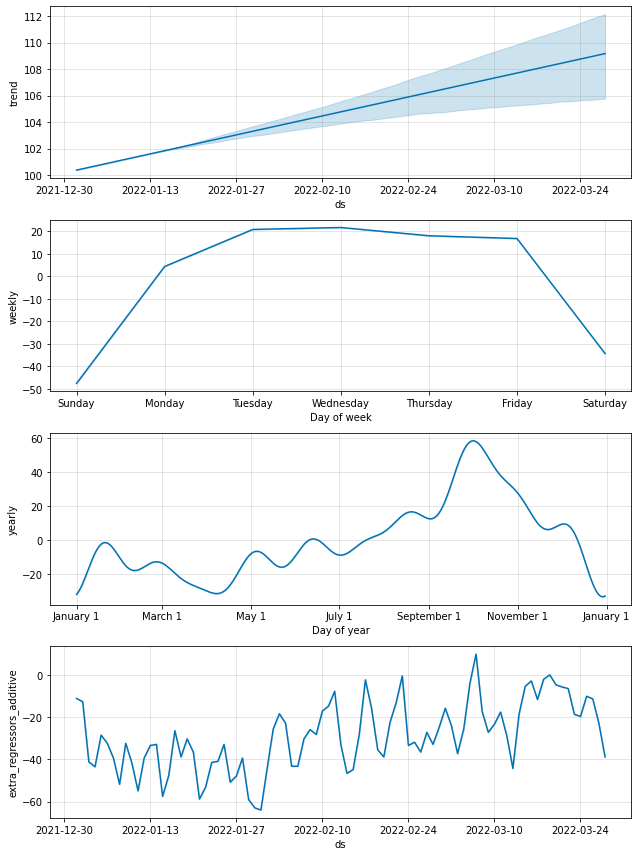

In [95]:
fig4 = m_train_R_ex1.plot_components(prophet_pred_train_R_ex1)

In [96]:
m_train_R_ex2 = Prophet()
m_train_R_ex2.add_regressor('precipitation_mm')
m_train_R_ex2.fit(history_prophet_R)
future_train_R_ex2 = m_train_R_ex2.make_future_dataframe(periods=0,freq='D')
prophet_pred_train_R_ex2 = m_train_R_ex2.predict(future_prophet_R)
prophet_pred_train_R_ex2

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2022-01-01  101.627945  -72.468500   27.400683   101.627945   101.627945   
1  2022-01-02  101.732431  -55.972145   40.280842   101.732431   101.732431   
2  2022-01-03  101.836917    1.938836   98.430083   101.836917   101.836917   
3  2022-01-04  101.941403   19.785418  117.838662   101.941403   101.941403   
4  2022-01-05  102.045889   16.910116  113.764772   102.045889   102.045889   
..        ...         ...         ...         ...          ...          ...   
82 2022-03-24  110.195781   20.070654  118.264047   107.280453   113.071357   
83 2022-03-25  110.300267   40.515692  138.187168   107.305484   113.190750   
84 2022-03-26  110.404753  -17.024911   82.943008   107.325024   113.428892   
85 2022-03-27  110.509238  -20.781616   71.830059   107.344651   113.574791   
86 2022-03-28  110.613724   23.633059  126.258115   107.364062   113.706250   

    additive_terms  additive_terms_lower  additive_terms_upper  \
0      -124.665774           -124.665774           -124.665774   
1      -109.441037           -109.441037           -109.441037   
2       -52.238645            -52.238645            -52.238645   
3       -31.709889            -31.709889            -31.709889   
4       -33.491474            -33.491474            -33.491474   
..             ...                   ...                   ...   
82      -42.983218            -42.983218            -42.983218   
83      -22.275919            -22.275919            -22.275919   
84      -77.104905            -77.104905            -77.104905   
85      -86.860773            -86.860773            -86.860773   
86      -36.368094            -36.368094            -36.368094   

    extra_regressors_additive  ...     weekly  weekly_lower  weekly_upper  \
0                  -28.982293  ... -35.694526    -35.694526    -35.694526   
1                   -2.164606  ... -47.889003    -47.889003    -47.889003   
2                    1.686870  ...   4.586181      4.586181      4.586181   
3                    5.253052  ...  20.426232     20.426232     20.426232   
4                    0.545692  ...  22.014796     22.014796     22.014796   
..                        ...  ...        ...           ...           ...   
82                 -16.999922  ...  18.410303     18.410303     18.410303   
83                   3.826579  ...  18.146016     18.146016     18.146016   
84                   2.685401  ... -35.694526    -35.694526    -35.694526   
85                   4.967757  ... -47.889003    -47.889003    -47.889003   
86                   2.828048  ...   4.586181      4.586181      4.586181   

       yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0  -59.988955    -59.988955    -59.988955                   0.0   
1  -59.387428    -59.387428    -59.387428                   0.0   
2  -58.511696    -58.511696    -58.511696                   0.0   
3  -57.389172    -57.389172    -57.389172                   0.0   
4  -56.051962    -56.051962    -56.051962                   0.0   
..        ...           ...           ...                   ...   
82 -44.393599    -44.393599    -44.393599                   0.0   
83 -44.248514    -44.248514    -44.248514                   0.0   
84 -44.095780    -44.095780    -44.095780                   0.0   
85 -43.939527    -43.939527    -43.939527                   0.0   
86 -43.782323    -43.782323    -43.782323                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper       yhat  
0                          0.0                         0.0 -23.037829  
1                          0.0                         0.0  -7.708606  
2                          0.0                         0.0  49.598272  
3                          0.0                         0.0  70.231514  
4                          0.0                         0.0  68.554414  
..                         ...                         ...        ...  
82                         0.0     

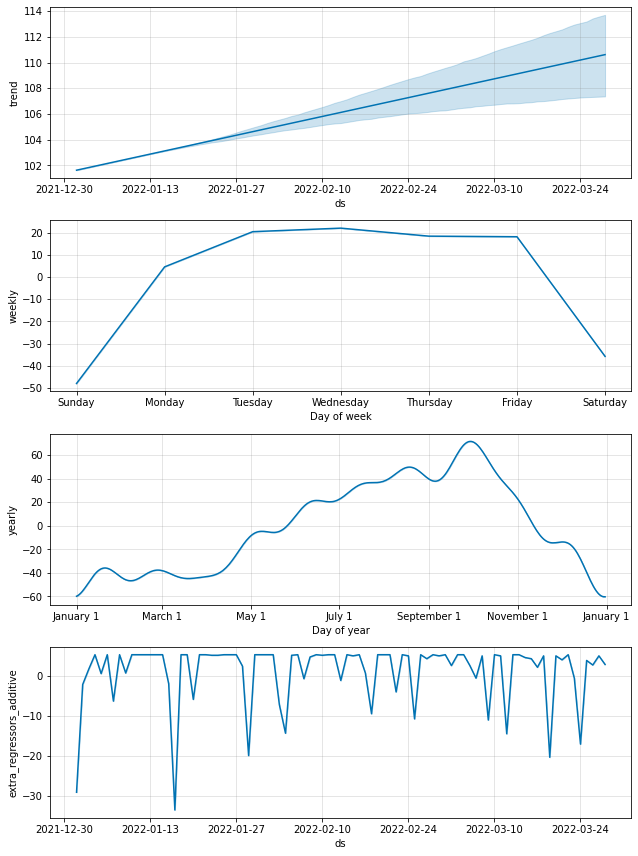

In [97]:
fig5 = m_train_R_ex2.plot_components(prophet_pred_train_R_ex2)

In [98]:
m_train_R_ex3 = Prophet()
m_train_R_ex3.add_regressor('windspeed_km/h')
m_train_R_ex3.fit(history_prophet_R)
future_train_R_ex3 = m_train_R_ex3.make_future_dataframe(periods=0,freq='D')
prophet_pred_train_R_ex3 = m_train_R_ex3.predict(future_prophet_R)
prophet_pred_train_R_ex3

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2022-01-01  101.975892  -43.607685   61.159971   101.975892   101.975892   
1  2022-01-02  102.082261  -55.337672   45.738810   102.082261   102.082261   
2  2022-01-03  102.188630   -7.430381   91.679149   102.188630   102.188630   
3  2022-01-04  102.294999   13.526262  115.883783   102.294999   102.294999   
4  2022-01-05  102.401367   17.279609  124.699104   102.401367   102.401367   
..        ...         ...         ...         ...          ...          ...   
82 2022-03-24  110.698134   27.548877  129.687471   107.629663   113.828314   
83 2022-03-25  110.804502   33.009295  135.022312   107.692337   113.994258   
84 2022-03-26  110.910871  -22.648467   80.255664   107.736877   114.160201   
85 2022-03-27  111.017240  -29.674738   75.309126   107.770583   114.340578   
86 2022-03-28  111.123609   24.104757  123.135408   107.797170   114.492087   

    additive_terms  additive_terms_lower  additive_terms_upper  \
0       -92.274291            -92.274291            -92.274291   
1      -108.462387           -108.462387           -108.462387   
2       -58.794638            -58.794638            -58.794638   
3       -35.230946            -35.230946            -35.230946   
4       -33.671633            -33.671633            -33.671633   
..             ...                   ...                   ...   
82      -32.116859            -32.116859            -32.116859   
83      -26.048519            -26.048519            -26.048519   
84      -79.616858            -79.616858            -79.616858   
85      -89.839431            -89.839431            -89.839431   
86      -36.755938            -36.755938            -36.755938   

    extra_regressors_additive  ...  windspeed_km/h  windspeed_km/h_lower  \
0                    1.952779  ...        1.952779              1.952779   
1                   -2.005003  ...       -2.005003             -2.005003   
2                   -5.511899  ...       -5.511899             -5.511899   
3                    0.299528  ...        0.299528              0.299528   
4                   -0.802639  ...       -0.802639             -0.802639   
..                        ...  ...             ...                   ...   
82                  -7.716234  ...       -7.716234             -7.716234   
83                  -0.602245  ...       -0.602245             -0.602245   
84                  -2.455890  ...       -2.455890             -2.455890   
85                   0.199331  ...        0.199331              0.199331   
86                   1.051006  ...        1.051006              1.051006   

    windspeed_km/h_upper     yearly  yearly_lower  yearly_upper  \
0               1.952779 -59.488344    -59.488344    -59.488344   
1              -2.005003 -58.713020    -58.713020    -58.713020   
2              -5.511899 -57.650872    -57.650872    -57.650872   
3               0.299528 -56.331489    -56.331489    -56.331489   
4              -0.802639 -54.789459    -54.789459    -54.789459   
..                   ...        ...           ...           ...   
82             -7.716234 -42.685791    -42.685791    -42.685791   
83             -0.602245 -42.554584    -42.554584    -42.554584   
84             -2.455890 -42.422242    -42.422242    -42.422242   
85              0.199331 -42.294398    -42.294398    -42.294398   
86              1.051006 -42.175077    -42.175077    -42.175077   

    multiplicative_terms  multiplicative_terms_lower  \
0                    0.0                         0.0   
1                    0.0                         0.0   
2                    0.0                         0.0   
3                    0.0                         0.0   
4                    0.0                         0.0   
..                   ...                         ...   
82                   0.0                         0.0   
83                   0.0                         0.0   
84                   0.0                       

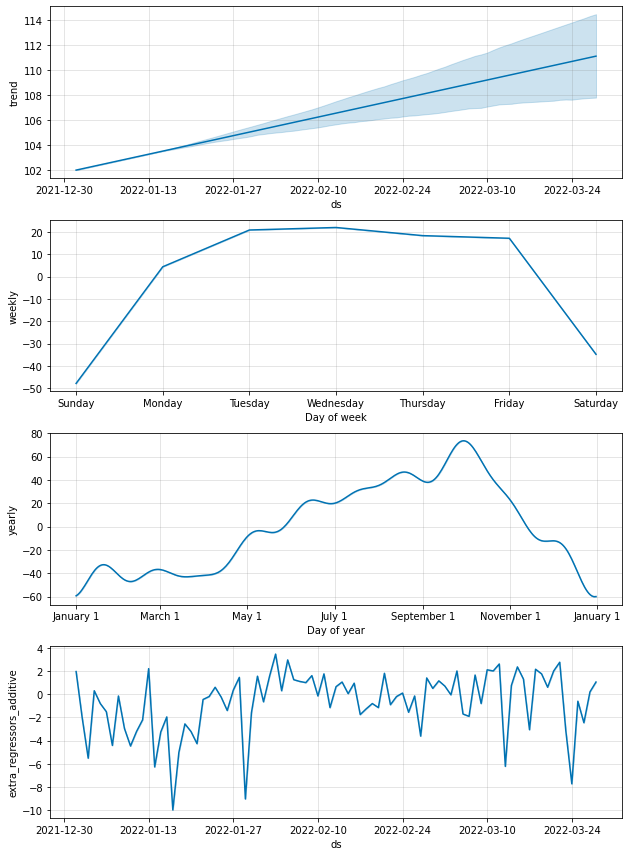

In [99]:
fig6 = m_train_R_ex3.plot_components(prophet_pred_train_R_ex3)

--Werte der Prognose

-Ausleihen

In [100]:
prophet_pred_train_A_ex1 = pd.DataFrame({'time': prophet_pred_train_A_ex1[-1584:]['ds'], 'Test_Prophet_Predictions_A': prophet_pred_train_A_ex1[-1584:]['yhat']})
prophet_pred_train_A_ex1 = prophet_pred_train_A_ex1.set_index('time')
prophet_pred_train_A_ex1.index.freq = 'D'
prophet_pred_train_A_ex1.tail(248)

Test_Prophet_Predictions_A
time                                  
2022-01-01                   39.833591
2022-01-02                   35.703187
2022-01-03                   52.650518
2022-01-04                   60.338074
2022-01-05                   76.798430
...                                ...
2022-03-24                   88.819937
2022-03-25                   90.353279
2022-03-26                   53.292760
2022-03-27                   39.011391
2022-03-28                   65.180946

[87 rows x 1 columns]

In [101]:
prophet_pred_train_A_ex2 = pd.DataFrame({'time': prophet_pred_train_A_ex2[-1584:]['ds'], 'Test_Prophet_Predictions_A': prophet_pred_train_A_ex2[-1584:]['yhat']})
prophet_pred_train_A_ex2 = prophet_pred_train_A_ex2.set_index('time')
prophet_pred_train_A_ex2.index.freq = 'D'
prophet_pred_train_A_ex2.tail(248)

Test_Prophet_Predictions_A
time                                  
2022-01-01                   -0.408917
2022-01-02                   23.166825
2022-01-03                   68.447024
2022-01-04                   80.580932
2022-01-05                   79.914046
...                                ...
2022-03-24                   78.293025
2022-03-25                   92.818449
2022-03-26                   53.693089
2022-03-27                   53.120194
2022-03-28                   91.735512

[87 rows x 1 columns]

In [102]:
prophet_pred_train_A_ex3 = pd.DataFrame({'time': prophet_pred_train_A_ex3[-1584:]['ds'], 'Test_Prophet_Predictions_A': prophet_pred_train_A_ex3[-1584:]['yhat']})
prophet_pred_train_A_ex3 = prophet_pred_train_A_ex3.set_index('time')
prophet_pred_train_A_ex3.index.freq = 'D'
prophet_pred_train_A_ex3.tail(248)

Test_Prophet_Predictions_A
time                                  
2022-01-01                   28.811723
2022-01-02                   21.764937
2022-01-03                   59.244198
2022-01-04                   75.024295
2022-01-05                   77.360248
...                                ...
2022-03-24                   85.048090
2022-03-25                   86.584228
2022-03-26                   48.364792
2022-03-27                   47.772011
2022-03-28                   88.952235

[87 rows x 1 columns]

-Rückgaben

In [103]:
prophet_pred_train_R_ex1 = pd.DataFrame({'time': prophet_pred_train_R_ex1[-1584:]['ds'], 'Test_Prophet_Predictions_R': prophet_pred_train_R_ex1[-1584:]['yhat']})
prophet_pred_train_R_ex1 = prophet_pred_train_R_ex1.set_index('time')
prophet_pred_train_R_ex1.index.freq = 'D'
prophet_pred_train_R_ex1.tail(248)

Test_Prophet_Predictions_R
time                                  
2022-01-01                   22.584972
2022-01-02                    8.879317
2022-01-03                   33.807783
2022-01-04                   49.610386
2022-01-05                   67.394070
...                                ...
2022-03-24                   79.827163
2022-03-25                   87.934512
2022-03-26                   35.234356
2022-03-27                   10.049252
2022-03-28                   45.997946

[87 rows x 1 columns]

In [104]:
prophet_pred_train_R_ex2 = pd.DataFrame({'time': prophet_pred_train_R_ex2[-1584:]['ds'], 'Test_Prophet_Predictions_R': prophet_pred_train_R_ex2[-1584:]['yhat']})
prophet_pred_train_R_ex2 = prophet_pred_train_R_ex2.set_index('time')
prophet_pred_train_R_ex2.index.freq = 'D'
prophet_pred_train_R_ex2.tail(248)

Test_Prophet_Predictions_R
time                                  
2022-01-01                  -23.037829
2022-01-02                   -7.708606
2022-01-03                   49.598272
2022-01-04                   70.231514
2022-01-05                   68.554414
...                                ...
2022-03-24                   67.212563
2022-03-25                   88.024348
2022-03-26                   33.299847
2022-03-27                   23.648465
2022-03-28                   74.245630

[87 rows x 1 columns]

In [105]:
prophet_pred_train_R_ex3 = pd.DataFrame({'time': prophet_pred_train_R_ex3[-1584:]['ds'], 'Test_Prophet_Predictions_R': prophet_pred_train_R_ex3[-1584:]['yhat']})
prophet_pred_train_R_ex3 = prophet_pred_train_R_ex3.set_index('time')
prophet_pred_train_R_ex3.index.freq = 'D'
prophet_pred_train_R_ex3.tail(248)

Test_Prophet_Predictions_R
time                                  
2022-01-01                    9.701602
2022-01-02                   -6.380126
2022-01-03                   43.393992
2022-01-04                   67.064053
2022-01-05                   68.729735
...                                ...
2022-03-24                   78.581275
2022-03-25                   84.755983
2022-03-26                   31.294013
2022-03-27                   21.177809
2022-03-28                   74.367671

[87 rows x 1 columns]

--Grafiken der Prognose

-Ausleihen

<AxesSubplot:xlabel='time'>

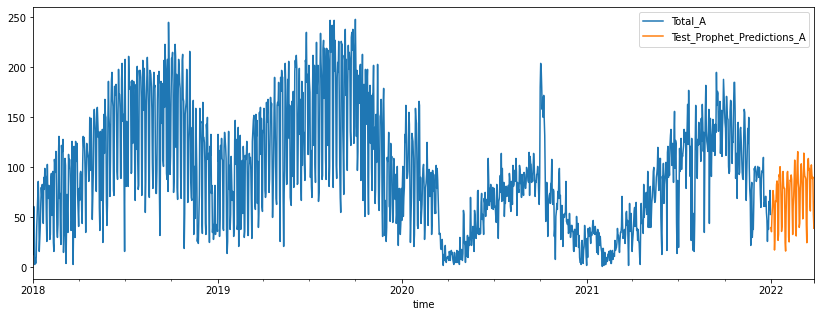

In [106]:
history_prophet_A['Total_A'].plot(figsize=(14,5), legend=True)
prophet_pred_train_A_ex1['Test_Prophet_Predictions_A'].plot(legend=True)

<AxesSubplot:xlabel='time'>

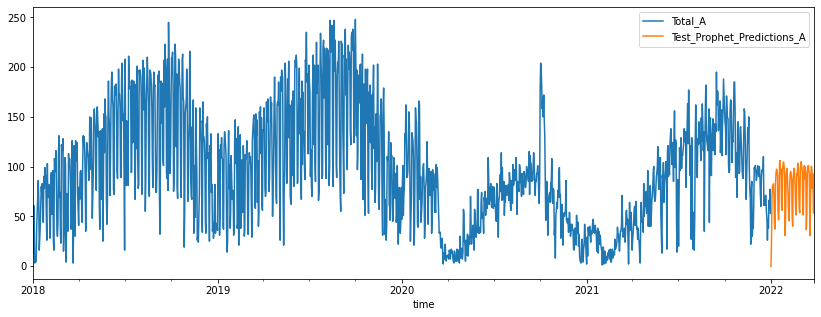

In [107]:
history_prophet_A['Total_A'].plot(figsize=(14,5), legend=True)
prophet_pred_train_A_ex2['Test_Prophet_Predictions_A'].plot(legend=True)

<AxesSubplot:xlabel='time'>

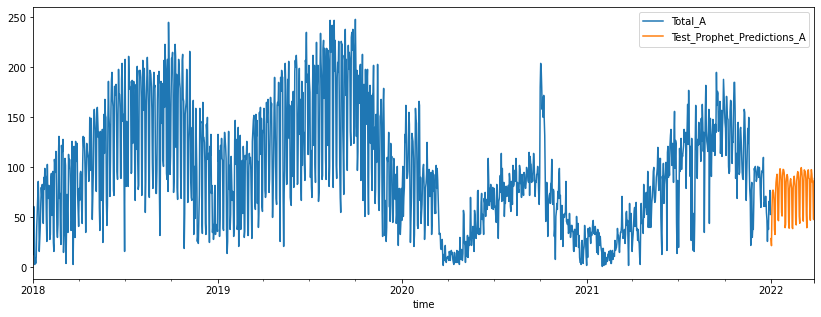

In [108]:
history_prophet_A['Total_A'].plot(figsize=(14,5), legend=True)
prophet_pred_train_A_ex3['Test_Prophet_Predictions_A'].plot(legend=True)

-Rückgaben

<AxesSubplot:xlabel='time'>

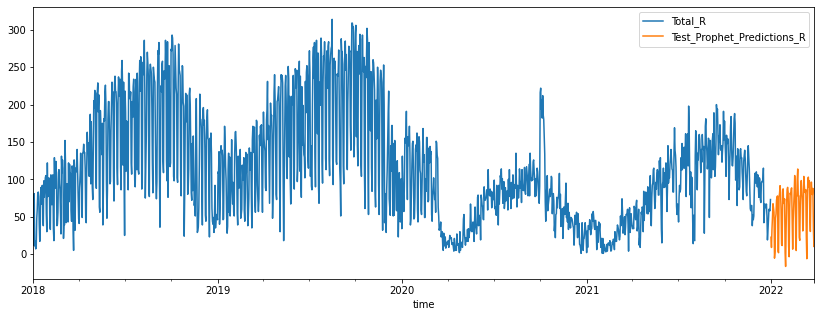

In [109]:
history_prophet_R['Total_R'].plot(figsize=(14,5), legend=True)
prophet_pred_train_R_ex1['Test_Prophet_Predictions_R'].plot(legend=True)

<AxesSubplot:xlabel='time'>

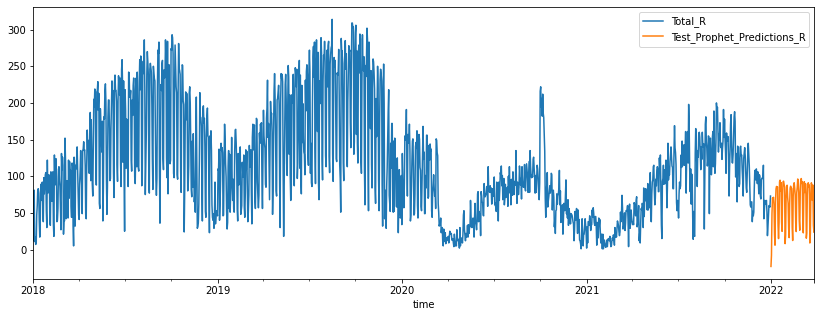

In [110]:
history_prophet_R['Total_R'].plot(figsize=(14,5), legend=True)
prophet_pred_train_R_ex2['Test_Prophet_Predictions_R'].plot(legend=True)

<AxesSubplot:xlabel='time'>

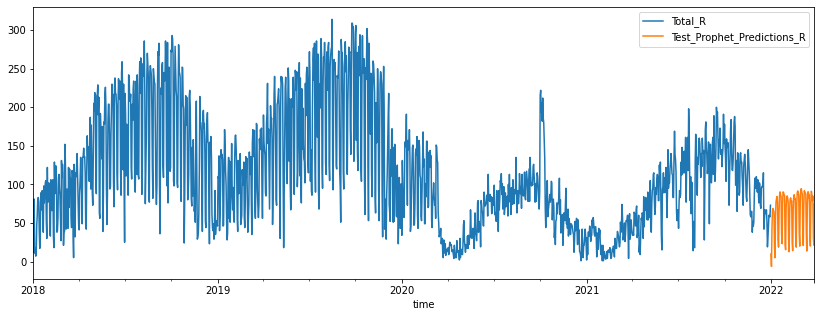

In [111]:
history_prophet_R['Total_R'].plot(figsize=(14,5), legend=True)
prophet_pred_train_R_ex3['Test_Prophet_Predictions_R'].plot(legend=True)

---Prognose der test-Daten

--Ausleihen

In [112]:
train_prophet_A = bike_prophet_AW[:1461]
test_prophet_A = bike_prophet_AW[-59:]

train_prophet_R = bike_prophet_RW[:1461]
test_prophet_R = bike_prophet_RW[-59:]

In [113]:
m_train_A_ex1_2 = Prophet()
m_train_A_ex1_2.add_regressor('avg_temp_C°')
m_train_A_ex1_2.fit(train_prophet_A)
future_train_A_ex1_2 = m_train_A_ex1_2.make_future_dataframe(periods=0,freq='D')
prophet_pred_train_A_ex1_2 = m_train_A_ex1_2.predict(test_prophet_A)
prophet_pred_train_A_ex1_2.tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
54 2022-02-24  108.246281   44.177129  124.416608   107.004781   109.365334   
55 2022-02-25  108.365175   41.085733  124.516221   107.059928   109.516312   
56 2022-02-26  108.484070   -1.381474   81.107717   107.114873   109.709192   
57 2022-02-27  108.602964    1.540973   85.940057   107.187404   109.868966   
58 2022-02-28  108.721859   40.783165  119.599436   107.276170   110.019496   

    additive_terms  additive_terms_lower  additive_terms_upper  avg_temp_C°  \
54      -23.910885            -23.910885            -23.910885   -28.824206   
55      -28.869525            -28.869525            -28.869525   -27.485179   
56      -68.483758            -68.483758            -68.483758   -31.502259   
57      -64.419945            -64.419945            -64.419945   -23.468099   
58      -29.356412            -29.356412            -29.356412   -28.377864   

    ...     weekly  weekly_lower  weekly_upper    yearly  yearly_lower  \
54  ...  13.667015     13.667015     13.667015 -8.753694     -8.753694   
55  ...   7.167955      7.167955      7.167955 -8.552301     -8.552301   
56  ... -28.541767    -28.541767    -28.541767 -8.439732     -8.439732   
57  ... -32.531835    -32.531835    -32.531835 -8.420010     -8.420010   
58  ...   7.515697      7.515697      7.515697 -8.494246     -8.494246   

    yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
54     -8.753694                   0.0                         0.0   
55     -8.552301                   0.0                         0.0   
56     -8.439732                   0.0                         0.0   
57     -8.420010                   0.0                         0.0   
58     -8.494246                   0.0                         0.0   

    multiplicative_terms_upper       yhat  
54                         0.0  84.335396  
55                         0.0  79.495650  
56                         0.0  40.000312  
57                         0.0  44.183019  
58                         0.0  79.365446  

[5 rows x 25 columns]

In [114]:
m_train_A_ex2_2 = Prophet()
m_train_A_ex2_2.add_regressor('precipitation_mm')
m_train_A_ex2_2.fit(train_prophet_A)
future_train_A_ex2_2 = m_train_A_ex2_2.make_future_dataframe(periods=0,freq='D')
prophet_pred_train_A_ex2_2 = m_train_A_ex2_2.predict(test_prophet_A)
prophet_pred_train_A_ex2_2.tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
54 2022-02-24  111.230654   58.325417  141.134899   110.284367   112.274389   
55 2022-02-25  111.361892   40.814623  121.561381   110.387071   112.428938   
56 2022-02-26  111.493131   19.736960   96.914430   110.465691   112.590395   
57 2022-02-27  111.624369   16.449897   96.838405   110.562231   112.767015   
58 2022-02-28  111.755607   53.918612  135.608333   110.657355   112.957208   

    additive_terms  additive_terms_lower  additive_terms_upper  \
54      -11.090208            -11.090208            -11.090208   
55      -31.415454            -31.415454            -31.415454   
56      -54.187081            -54.187081            -54.187081   
57      -57.998710            -57.998710            -57.998710   
58      -16.563726            -16.563726            -16.563726   

    extra_regressors_additive  ...     weekly  weekly_lower  weekly_upper  \
54                   4.750760  ...  13.976626     13.976626     13.976626   
55                 -10.255031  ...   8.389270      8.389270      8.389270   
56                   5.023593  ... -29.836988    -29.836988    -29.836988   
57                   4.068679  ... -32.776783    -32.776783    -32.776783   
58                   5.023593  ...   7.711323      7.711323      7.711323   

       yearly  yearly_lower  yearly_upper  multiplicative_terms  \
54 -29.817593    -29.817593    -29.817593                   0.0   
55 -29.549693    -29.549693    -29.549693                   0.0   
56 -29.373686    -29.373686    -29.373686                   0.0   
57 -29.290606    -29.290606    -29.290606                   0.0   
58 -29.298641    -29.298641    -29.298641                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper        yhat  
54                         0.0                         0.0  100.140447  
55                         0.0                         0.0   79.946439  
56                         0.0                         0.0   57.306049  
57                         0.0                         0.0   53.625658  
58                         0.0                         0.0   95.191881  

[5 rows x 25 columns]

In [115]:
m_train_A_ex3_2 = Prophet()
m_train_A_ex3_2.add_regressor('windspeed_km/h')
m_train_A_ex3_2.fit(train_prophet_A)
future_train_A_ex3_2 = m_train_A_ex3_2.make_future_dataframe(periods=0,freq='D')
prophet_pred_train_A_ex3_2 = m_train_A_ex3_2.predict(test_prophet_A)
prophet_pred_train_A_ex3_2.tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
54 2022-02-24  109.007495   49.557677  133.258383   107.847446   109.973803   
55 2022-02-25  109.128572   41.863076  129.224144   107.930606   110.143006   
56 2022-02-26  109.249649    6.946689   97.334693   107.997062   110.299189   
57 2022-02-27  109.370726    1.495110   85.490890   108.073180   110.448313   
58 2022-02-28  109.491803   45.683737  131.927975   108.167612   110.603546   

    additive_terms  additive_terms_lower  additive_terms_upper  \
54      -15.686525            -15.686525            -15.686525   
55      -23.534397            -23.534397            -23.534397   
56      -57.995435            -57.995435            -57.995435   
57      -65.223186            -65.223186            -65.223186   
58      -19.458814            -19.458814            -19.458814   

    extra_regressors_additive  ...  windspeed_km/h  windspeed_km/h_lower  \
54                   0.109078  ...        0.109078              0.109078   
55                  -1.710012  ...       -1.710012             -1.710012   
56                  -0.166541  ...       -0.166541             -0.166541   
57                  -3.970093  ...       -3.970093             -3.970093   
58                   1.542301  ...        1.542301              1.542301   

    windspeed_km/h_upper     yearly  yearly_lower  yearly_upper  \
54              0.109078 -29.661712    -29.661712    -29.661712   
55             -1.710012 -29.226171    -29.226171    -29.226171   
56             -0.166541 -28.887140    -28.887140    -28.887140   
57             -3.970093 -28.648015    -28.648015    -28.648015   
58              1.542301 -28.509011    -28.509011    -28.509011   

    multiplicative_terms  multiplicative_terms_lower  \
54                   0.0                         0.0   
55                   0.0                         0.0   
56                   0.0                         0.0   
57                   0.0                         0.0   
58                   0.0                         0.0   

    multiplicative_terms_upper       yhat  
54                         0.0  93.320970  
55                         0.0  85.594175  
56                         0.0  51.254214  
57                         0.0  44.147540  
58                         0.0  90.032989  

[5 rows x 25 columns]

--Rückgaben

In [116]:
m_train_R_ex1_2 = Prophet()
m_train_R_ex1_2.add_regressor('avg_temp_C°')
m_train_R_ex1_2.fit(train_prophet_R)
future_train_R_ex1_2 = m_train_R_ex1_2.make_future_dataframe(periods=0,freq='D')
prophet_pred_train_R_ex1_2 = m_train_R_ex1_2.predict(test_prophet_R)
prophet_pred_train_R_ex1_2.tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
54 2022-02-24  105.900410   26.294787  129.628780   104.778978   107.348624   
55 2022-02-25  106.002670   26.150153  129.999234   104.808032   107.515922   
56 2022-02-26  106.104931  -26.072882   74.165104   104.859048   107.678354   
57 2022-02-27  106.207191  -35.249576   71.064450   104.898984   107.835252   
58 2022-02-28  106.309451   12.468336  118.402537   104.937018   108.002219   

    additive_terms  additive_terms_lower  additive_terms_upper  avg_temp_C°  \
54      -28.327633            -28.327633            -28.327633   -33.446641   
55      -27.914535            -27.914535            -27.914535   -31.892880   
56      -83.755974            -83.755974            -83.755974   -36.554164   
57      -87.846844            -87.846844            -87.846844   -27.231595   
58      -41.783855            -41.783855            -41.783855   -32.928721   

    ...     weekly  weekly_lower  weekly_upper     yearly  yearly_lower  \
54  ...  18.068215     18.068215     18.068215 -12.949206    -12.949206   
55  ...  16.841942     16.841942     16.841942 -12.863596    -12.863596   
56  ... -34.316334    -34.316334    -34.316334 -12.885475    -12.885475   
57  ... -47.598702    -47.598702    -47.598702 -13.016547    -13.016547   
58  ...   4.400306      4.400306      4.400306 -13.255440    -13.255440   

    yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
54    -12.949206                   0.0                         0.0   
55    -12.863596                   0.0                         0.0   
56    -12.885475                   0.0                         0.0   
57    -13.016547                   0.0                         0.0   
58    -13.255440                   0.0                         0.0   

    multiplicative_terms_upper       yhat  
54                         0.0  77.572778  
55                         0.0  78.088136  
56                         0.0  22.348957  
57                         0.0  18.360347  
58                         0.0  64.525595  

[5 rows x 25 columns]

In [117]:
m_train_R_ex2_2 = Prophet()
m_train_R_ex2_2.add_regressor('precipitation_mm')
m_train_R_ex2_2.fit(train_prophet_R)
future_train_R_ex2_2 = m_train_R_ex2_2.make_future_dataframe(periods=0,freq='D')
prophet_pred_train_R_ex2_2 = m_train_R_ex2_2.predict(test_prophet_R)
prophet_pred_train_R_ex2_2.tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
54 2022-02-24  107.270179   46.980316  140.720743   105.588559   108.846967   
55 2022-02-25  107.374664   28.861453  124.702123   105.625662   109.003556   
56 2022-02-26  107.479150   -8.846820   84.925661   105.665223   109.165963   
57 2022-02-27  107.583636  -24.096361   75.558984   105.680367   109.334146   
58 2022-02-28  107.688122   27.716883  127.067616   105.735623   109.502506   

    additive_terms  additive_terms_lower  additive_terms_upper  \
54      -14.508251            -14.508251            -14.508251   
55      -30.269396            -30.269396            -30.269396   
56      -68.050075            -68.050075            -68.050075   
57      -81.269173            -81.269173            -81.269173   
58      -27.926473            -27.926473            -27.926473   

    extra_regressors_additive  ...     weekly  weekly_lower  weekly_upper  \
54                   4.967757  ...  18.410303     18.410303     18.410303   
55                 -10.723442  ...  18.146016     18.146016     18.146016   
56                   5.253052  ... -35.694526    -35.694526    -35.694526   
57                   4.254521  ... -47.889003    -47.889003    -47.889003   
58                   5.253052  ...   4.586181      4.586181      4.586181   

       yearly  yearly_lower  yearly_upper  multiplicative_terms  \
54 -37.886311    -37.886311    -37.886311                   0.0   
55 -37.691970    -37.691970    -37.691970                   0.0   
56 -37.608601    -37.608601    -37.608601                   0.0   
57 -37.634691    -37.634691    -37.634691                   0.0   
58 -37.765706    -37.765706    -37.765706                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper       yhat  
54                         0.0                         0.0  92.761928  
55                         0.0                         0.0  77.105268  
56                         0.0                         0.0  39.429075  
57                         0.0                         0.0  26.314463  
58                         0.0                         0.0  79.761649  

[5 rows x 25 columns]

In [118]:
m_train_R_ex3_2 = Prophet()
m_train_R_ex3_2.add_regressor('windspeed_km/h')
m_train_R_ex3_2.fit(train_prophet_R)
future_train_R_ex3_2 = m_train_R_ex3_2.make_future_dataframe(periods=0,freq='D')
prophet_pred_train_R_ex3_2 = m_train_R_ex3_2.predict(test_prophet_R)
prophet_pred_train_R_ex3_2.tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
54 2022-02-24  107.719807   38.111029  142.254391   106.388957   109.187257   
55 2022-02-25  107.826176   30.959479  137.212031   106.428959   109.337945   
56 2022-02-26  107.932545  -18.545336   87.063532   106.492800   109.478989   
57 2022-02-27  108.038914  -32.123251   70.521631   106.557935   109.630223   
58 2022-02-28  108.145283   24.220505  129.161793   106.586413   109.787687   

    additive_terms  additive_terms_lower  additive_terms_upper  \
54      -18.978909            -18.978909            -18.978909   
55      -21.463385            -21.463385            -21.463385   
56      -71.678722            -71.678722            -71.678722   
57      -88.029534            -88.029534            -88.029534   
58      -30.910124            -30.910124            -30.910124   

    extra_regressors_additive  ...  windspeed_km/h  windspeed_km/h_lower  \
54                   0.099134  ...        0.099134              0.099134   
55                  -1.554117  ...       -1.554117             -1.554117   
56                  -0.151359  ...       -0.151359             -0.151359   
57                  -3.608156  ...       -3.608156             -3.608156   
58                   1.401695  ...        1.401695              1.401695   

    windspeed_km/h_upper     yearly  yearly_lower  yearly_upper  \
54              0.099134 -37.363209    -37.363209    -37.363209   
55             -1.554117 -37.017578    -37.017578    -37.017578   
56             -0.151359 -36.788637    -36.788637    -36.788637   
57             -3.608156 -36.677014    -36.677014    -36.677014   
58              1.401695 -36.679953    -36.679953    -36.679953   

    multiplicative_terms  multiplicative_terms_lower  \
54                   0.0                         0.0   
55                   0.0                         0.0   
56                   0.0                         0.0   
57                   0.0                         0.0   
58                   0.0                         0.0   

    multiplicative_terms_upper       yhat  
54                         0.0  88.740898  
55                         0.0  86.362791  
56                         0.0  36.253823  
57                         0.0  20.009380  
58                         0.0  77.235159  

[5 rows x 25 columns]

---Werte der Prognosen

--Ausleihen

In [119]:
prophet_pred_train_A_ex1_2 = pd.DataFrame({'time': prophet_pred_train_A_ex1_2[-1520:]['ds'], 'Test_Prophet_Predictions_A': prophet_pred_train_A_ex1_2[-1520:]['yhat']})
prophet_pred_train_A_ex1_2 = prophet_pred_train_A_ex1_2.set_index('time')
prophet_pred_train_A_ex1_2.index.freq = 'D'
prophet_pred_train_A_ex1_2.tail(59)

Test_Prophet_Predictions_A
time                                  
2022-01-01                   39.833591
2022-01-02                   35.703187
2022-01-03                   52.650518
2022-01-04                   60.338074
2022-01-05                   76.798430
2022-01-06                   71.963965
2022-01-07                   61.594657
2022-01-08                   17.412464
2022-01-09                   32.442779
2022-01-10                   66.739296
2022-01-11                   65.621689
2022-01-12                   82.819002
2022-01-13                   86.473839
2022-01-14                   82.305642
2022-01-15                   27.092553
2022-01-16                   33.067538
2022-01-17                   92.664754
2022-01-18                   90.973552
2022-01-19                  100.722920
2022-01-20                   92.321291
2022-01-21                   66.838457
2022-01-22                   35.991459
2022-01-23                   41.754045
2022-01-24                   81.732858
2022-01-25                   95.955777
2022-01-26                   81.309999
2022-01-27                   79.205824
2022-01-28                   78.914728
2022-01-29                   25.004624
2022-01-30                   16.378350
2022-01-31                   54.228424
2022-02-01                   77.699604
2022-02-02                   94.395182
2022-02-03                   95.956563
2022-02-04                   84.591977
2022-02-05                   30.298586
2022-02-06                   25.490391
2022-02-07                   76.025582
2022-02-08                   87.325796
2022-02-09                   86.606481
2022-02-10                   92.484018
2022-02-11                   87.944207
2022-02-12                   58.353136
2022-02-13                   32.938151
2022-02-14                   61.494337
2022-02-15                   71.511584
2022-02-16                   87.950687
2022-02-17                  107.314433
2022-02-18                   89.809209
2022-02-19                   37.750144
2022-02-20                   31.462983
2022-02-21                   86.147727
2022-02-22                  102.737489
2022-02-23                  115.793967
2022-02-24                   84.335396
2022-02-25                   79.495650
2022-02-26                   40.000312
2022-02-27                   44.183019
2022-02-28                   79.365446

In [120]:
prophet_pred_train_A_ex2_2 = pd.DataFrame({'time': prophet_pred_train_A_ex2_2[-1520:]['ds'], 'Test_Prophet_Predictions_A': prophet_pred_train_A_ex2_2[-1520:]['yhat']})
prophet_pred_train_A_ex2_2 = prophet_pred_train_A_ex2_2.set_index('time')
prophet_pred_train_A_ex2_2.index.freq = 'D'
prophet_pred_train_A_ex2_2.tail(59)

Test_Prophet_Predictions_A
time                                  
2022-01-01                   -0.408917
2022-01-02                   23.166825
2022-01-03                   68.447024
2022-01-04                   80.580932
2022-01-05                   79.914046
2022-01-06                   82.639444
2022-01-07                   67.801451
2022-01-08                   42.511455
2022-01-09                   37.141986
2022-01-10                   83.941250
2022-01-11                   93.256273
2022-01-12                   97.427152
2022-01-13                   95.727564
2022-01-14                   91.759277
2022-01-15                   54.991473
2022-01-16                   46.368498
2022-01-17                   57.915773
2022-01-18                  103.135918
2022-01-19                  106.083553
2022-01-20                   92.393112
2022-01-21                   97.622665
2022-01-22                   59.356423
2022-01-23                   56.037034
2022-01-24                   96.096506
2022-01-25                  103.038021
2022-01-26                  104.625667
2022-01-27                  100.332019
2022-01-28                   91.091732
2022-01-29                   30.608106
2022-01-30                   50.679698
2022-01-31                   90.178189
2022-02-01                   96.622651
2022-02-02                   98.051236
2022-02-03                   81.927833
2022-02-04                   68.821953
2022-02-05                   48.573465
2022-02-06                   45.330585
2022-02-07                   79.793321
2022-02-08                   92.226378
2022-02-09                   95.090038
2022-02-10                   91.644742
2022-02-11                   86.471048
2022-02-12                   48.645588
2022-02-13                   40.076979
2022-02-14                   87.305994
2022-02-15                   95.106396
2022-02-16                   98.427425
2022-02-17                   91.373346
2022-02-18                   76.875223
2022-02-19                   53.467123
2022-02-20                   51.268300
2022-02-21                   92.453930
2022-02-22                   91.623423
2022-02-23                  103.377334
2022-02-24                  100.140447
2022-02-25                   79.946439
2022-02-26                   57.306049
2022-02-27                   53.625658
2022-02-28                   95.191881

In [121]:
prophet_pred_train_A_ex3_2 = pd.DataFrame({'time': prophet_pred_train_A_ex3_2[-1520:]['ds'], 'Test_Prophet_Predictions_A': prophet_pred_train_A_ex3_2[-1520:]['yhat']})
prophet_pred_train_A_ex3_2 = prophet_pred_train_A_ex3_2.set_index('time')
prophet_pred_train_A_ex3_2.index.freq = 'D'
prophet_pred_train_A_ex3_2.tail(59)

Test_Prophet_Predictions_A
time                                  
2022-01-01                   28.811723
2022-01-02                   21.764937
2022-01-03                   59.244198
2022-01-04                   75.024295
2022-01-05                   77.360248
2022-01-06                   74.945434
2022-01-07                   67.237431
2022-01-08                   37.623950
2022-01-09                   32.967964
2022-01-10                   73.529277
2022-01-11                   84.906551
2022-01-12                   89.896100
2022-01-13                   93.162442
2022-01-14                   79.116219
2022-01-15                   47.635713
2022-01-16                   46.756369
2022-01-17                   79.174248
2022-01-18                   93.445717
2022-01-19                   98.672006
2022-01-20                   94.866682
2022-01-21                   87.369826
2022-01-22                   55.096865
2022-01-23                   51.360257
2022-01-24                   91.795147
2022-01-25                   98.041200
2022-01-26                   97.758046
2022-01-27                   95.182385
2022-01-28                   88.793661
2022-01-29                   39.727592
2022-01-30                   42.990548
2022-01-31                   85.347439
2022-02-01                   89.659594
2022-02-02                   92.850531
2022-02-03                   90.444630
2022-02-04                   79.590033
2022-02-05                   45.387805
2022-02-06                   39.222989
2022-02-07                   78.707477
2022-02-08                   86.235777
2022-02-09                   88.670395
2022-02-10                   83.324559
2022-02-11                   79.166899
2022-02-12                   39.989438
2022-02-13                   38.810528
2022-02-14                   79.983529
2022-02-15                   87.530226
2022-02-16                   91.211255
2022-02-17                   85.618879
2022-02-18                   80.587801
2022-02-19                   45.631311
2022-02-20                   42.460188
2022-02-21                   86.670412
2022-02-22                   92.418328
2022-02-23                   95.809758
2022-02-24                   93.320970
2022-02-25                   85.594175
2022-02-26                   51.254214
2022-02-27                   44.147540
2022-02-28                   90.032989

In [122]:
prophet_pred_train_R_ex1_2 = pd.DataFrame({'time': prophet_pred_train_R_ex1_2[-1520:]['ds'], 'Test_Prophet_Predictions_R': prophet_pred_train_R_ex1_2[-1520:]['yhat']})
prophet_pred_train_R_ex1_2 = prophet_pred_train_R_ex1_2.set_index('time')
prophet_pred_train_R_ex1_2.index.freq = 'D'
prophet_pred_train_R_ex1_2.tail(59)

Test_Prophet_Predictions_R
time                                  
2022-01-01                   22.584972
2022-01-02                    8.879317
2022-01-03                   33.807783
2022-01-04                   49.610386
2022-01-05                   67.394070
2022-01-06                   61.904989
2022-01-07                   55.890912
2022-01-08                   -5.401331
2022-01-09                    3.080592
2022-01-10                   48.099536
2022-01-11                   53.654392
2022-01-12                   72.278206
2022-01-13                   76.644950
2022-01-14                   77.855651
2022-01-15                    3.820014
2022-01-16                    1.880495
2022-01-17                   76.374503
2022-01-18                   81.412041
2022-01-19                   91.572414
2022-01-20                   82.157163
2022-01-21                   58.869460
2022-01-22                   13.364848
2022-01-23                   11.455170
2022-01-24                   63.474998
2022-01-25                   87.277845
2022-01-26                   69.433077
2022-01-27                   67.624561
2022-01-28                   73.859207
2022-01-29                    1.869202
2022-01-30                  -16.480480
2022-01-31                   33.300615
2022-02-01                   68.036769
2022-02-02                   86.728132
2022-02-03                   89.305365
2022-02-04                   82.784539
2022-02-05                   10.403757
2022-02-06                   -3.501875
2022-02-07                   60.972455
2022-02-08                   81.521179
2022-02-09                   79.903877
2022-02-10                   87.354960
2022-02-11                   88.588974
2022-02-12                   44.681693
2022-02-13                    6.653066
2022-02-14                   45.395617
2022-02-15                   64.216025
2022-02-16                   82.262684
2022-02-17                  105.115068
2022-02-18                   91.059996
2022-02-19                   20.844767
2022-02-20                    4.786201
2022-02-21                   73.637365
2022-02-22                   99.892299
2022-02-23                  113.842310
2022-02-24                   77.572778
2022-02-25                   78.088136
2022-02-26                   22.348957
2022-02-27                   18.360347
2022-02-28                   64.525595

In [123]:
prophet_pred_train_R_ex2_2 = pd.DataFrame({'time': prophet_pred_train_R_ex2_2[-1520:]['ds'], 'Test_Prophet_Predictions_R': prophet_pred_train_R_ex2_2[-1520:]['yhat']})
prophet_pred_train_R_ex2_2 = prophet_pred_train_R_ex2_2.set_index('time')
prophet_pred_train_R_ex2_2.index.freq = 'D'
prophet_pred_train_R_ex2_2.tail(59)

Test_Prophet_Predictions_R
time                                  
2022-01-01                  -23.037829
2022-01-02                   -7.708606
2022-01-03                   49.598272
2022-01-04                   70.231514
2022-01-05                   68.554414
2022-01-06                   71.277670
2022-01-07                   61.219052
2022-01-08                   20.791733
2022-01-09                    5.947997
2022-01-10                   64.917955
2022-01-11                   82.661617
2022-01-12                   86.088237
2022-01-13                   84.219995
2022-01-14                   85.557571
2022-01-15                   33.156292
2022-01-16                   14.940216
2022-01-17                   37.082707
2022-01-18                   92.414019
2022-01-19                   94.614274
2022-01-20                   80.272361
2022-01-21                   91.306223
2022-01-22                   37.430533
2022-01-23                   24.866993
2022-01-24                   76.944417
2022-01-25                   92.381668
2022-01-26                   93.303744
2022-01-27                   88.940554
2022-01-28                   85.002599
2022-01-29                    8.057009
2022-01-30                   20.115354
2022-01-31                   71.765582
2022-02-01                   86.836061
2022-02-02                   87.735076
2022-02-03                   71.132177
2022-02-04                   63.266635
2022-02-05                   28.490109
2022-02-06                   16.244510
2022-02-07                   62.681908
2022-02-08                   84.043616
2022-02-09                   86.447684
2022-02-10                   83.081448
2022-02-11                   83.465146
2022-02-12                   30.239566
2022-02-13                   12.333029
2022-02-14                   72.006863
2022-02-15                   88.392464
2022-02-16                   91.126522
2022-02-17                   83.824740
2022-02-18                   74.285491
2022-02-19                   35.955624
2022-02-20                   24.525260
2022-02-21                   77.693905
2022-02-22                   84.870498
2022-02-23                   96.243597
2022-02-24                   92.761928
2022-02-25                   77.105268
2022-02-26                   39.429075
2022-02-27                   26.314463
2022-02-28                   79.761649

In [124]:
prophet_pred_train_R_ex3_2 = pd.DataFrame({'time': prophet_pred_train_R_ex3_2[-1520:]['ds'], 'Test_Prophet_Predictions_R': prophet_pred_train_R_ex3_2[-1520:]['yhat']})
prophet_pred_train_R_ex3_2 = prophet_pred_train_R_ex3_2.set_index('time')
prophet_pred_train_R_ex3_2.index.freq = 'D'
prophet_pred_train_R_ex3_2.tail(59)

Test_Prophet_Predictions_R
time                                  
2022-01-01                    9.701602
2022-01-02                   -6.380126
2022-01-03                   43.393992
2022-01-04                   67.064053
2022-01-05                   68.729735
2022-01-06                   66.225343
2022-01-07                   64.116965
2022-01-08                   18.600194
2022-01-09                    4.913269
2022-01-10                   57.653931
2022-01-11                   77.432827
2022-01-12                   81.567791
2022-01-13                   84.235243
2022-01-14                   76.330787
2022-01-15                   29.042752
2022-01-16                   18.681182
2022-01-17                   63.888020
2022-01-18                   86.145689
2022-01-19                   90.332617
2022-01-20                   86.405357
2022-01-21                   84.287717
2022-01-22                   36.122652
2022-01-23                   23.021931
2022-01-24                   75.392047
2022-01-25                   90.256838
2022-01-26                   89.364542
2022-01-27                   86.512150
2022-01-28                   85.389585
2022-01-29                   21.981254
2022-01-30                   15.291034
2022-01-31                   69.485462
2022-02-01                   82.696084
2022-02-02                   85.087110
2022-02-03                   82.533437
2022-02-04                   77.510472
2022-02-05                   27.778176
2022-02-06                   12.690651
2022-02-07                   64.443912
2022-02-08                   80.739987
2022-02-09                   82.594249
2022-02-10                   77.502668
2022-02-11                   78.679295
2022-02-12                   24.514073
2022-02-13                   14.019241
2022-02-14                   67.338807
2022-02-15                   83.652327
2022-02-16                   86.608526
2022-02-17                   81.230734
2022-02-18                   81.521196
2022-02-19                   31.071390
2022-02-20                   18.619414
2022-02-21                   74.530146
2022-02-22                   89.020827
2022-02-23                   91.511062
2022-02-24                   88.740898
2022-02-25                   86.362791
2022-02-26                   36.253823
2022-02-27                   20.009380
2022-02-28                   77.235159

In [125]:
test_prophet_A['Test_Prophet_Predictions_A_temp'] = prophet_pred_train_A_ex1_2['Test_Prophet_Predictions_A']
test_prophet_A['Test_Prophet_Predictions_A_preci'] = prophet_pred_train_A_ex2_2['Test_Prophet_Predictions_A']
test_prophet_A['Test_Prophet_Predictions_A_wind'] = prophet_pred_train_A_ex3_2['Test_Prophet_Predictions_A']

test_prophet_R['Test_Prophet_Predictions_R_temp'] = prophet_pred_train_R_ex1_2['Test_Prophet_Predictions_R']
test_prophet_R['Test_Prophet_Predictions_R_preci'] = prophet_pred_train_R_ex2_2['Test_Prophet_Predictions_R']
test_prophet_R['Test_Prophet_Predictions_R_wind'] = prophet_pred_train_R_ex3_2['Test_Prophet_Predictions_R']

c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

---Fehlermaß ermitteln

--Ausleihen

In [126]:
test_prophet_rmse_error_A_ex1 = rmse(test_prophet_A['Total_A'], test_prophet_A['Test_Prophet_Predictions_A_temp'])
test_prophet_mse_error_A_ex1 = test_prophet_rmse_error_A_ex1**2
test_prophet_mape_error_A_ex1 = mean_absolute_error(test_prophet_A['Total_A'], test_prophet_A['Test_Prophet_Predictions_A_temp'])
test_mean_value_A_ex1 = bike_prophet_AW['Total_A'].mean()

print(f'RMSE Error: {test_prophet_rmse_error_A_ex1}\nMSE Error: {test_prophet_mse_error_A_ex1}\nMAPE Error: {test_prophet_mape_error_A_ex1}\nMean: {test_mean_value_A_ex1}')

RMSE Error: 23.752726866299128
MSE Error: 564.1920335850084
MAPE Error: 17.938109157788254
Mean: 94.2296052631579


In [127]:
test_prophet_rmse_error_A_ex2 = rmse(test_prophet_A['Total_A'], test_prophet_A['Test_Prophet_Predictions_A_preci'])
test_prophet_mse_error_A_ex2 = test_prophet_rmse_error_A_ex2**2
test_prophet_mape_error_A_ex2 = mean_absolute_error(test_prophet_A['Total_A'], test_prophet_A['Test_Prophet_Predictions_A_preci'])
test_mean_value_A_ex2 = bike_prophet_AW['Total_A'].mean()

print(f'RMSE Error: {test_prophet_rmse_error_A_ex2}\nMSE Error: {test_prophet_mse_error_A_ex2}\nMAPE Error: {test_prophet_mape_error_A_ex2}\nMean: {test_mean_value_A_ex2}')

RMSE Error: 31.17717309337216
MSE Error: 972.016122094089
MAPE Error: 26.51917487017754
Mean: 94.2296052631579


In [128]:
test_prophet_rmse_error_A_ex3 = rmse(test_prophet_A['Total_A'], test_prophet_A['Test_Prophet_Predictions_A_wind'])
test_prophet_mse_error_A_ex3 = test_prophet_rmse_error_A_ex3**2
test_prophet_mape_error_A_ex3 = mean_absolute_error(test_prophet_A['Total_A'], test_prophet_A['Test_Prophet_Predictions_A_wind'])
test_mean_value_A_ex3 = bike_prophet_AW['Total_A'].mean()

print(f'RMSE Error: {test_prophet_rmse_error_A_ex3}\nMSE Error: {test_prophet_mse_error_A_ex3}\nMAPE Error: {test_prophet_mape_error_A_ex3}\nMean: {test_mean_value_A_ex3}')

RMSE Error: 28.317041955998775
MSE Error: 801.854865137795
MAPE Error: 22.880280746725614
Mean: 94.2296052631579


In [129]:
rmse_prophet_A = pd.DataFrame({"Wetterart" : ["Durchschnittstemperatur", "Niederschlagsmenge", "Windgeschwindigkeit"], "RMSE der Ausleihen in Prophet" : (test_prophet_rmse_error_A_ex1, test_prophet_rmse_error_A_ex2, test_prophet_rmse_error_A_ex3)})
rmse_prophet_A

Wetterart  RMSE der Ausleihen in Prophet
0  Durchschnittstemperatur                      23.752727
1       Niederschlagsmenge                      31.177173
2      Windgeschwindigkeit                      28.317042

--Rückgaben

In [130]:
test_prophet_rmse_error_R_ex1 = rmse(test_prophet_R['Total_R'], test_prophet_R['Test_Prophet_Predictions_R_temp'])
test_prophet_mse_error_R_ex1 = test_prophet_rmse_error_R_ex1**2
test_prophet_mape_error_R_ex1 = mean_absolute_error(test_prophet_R['Total_R'], test_prophet_R['Test_Prophet_Predictions_R_temp'])
test_mean_value_R_ex1 = bike_prophet_RW['Total_R'].mean()

print(f'RMSE Error: {test_prophet_rmse_error_R_ex1}\nMSE Error: {test_prophet_mse_error_R_ex1}\nMAPE Error: {test_prophet_mape_error_R_ex1}\nMean: {test_mean_value_R_ex1}')

RMSE Error: 22.00860070641889
MSE Error: 484.37850505458204
MAPE Error: 18.020346544338857
Mean: 111.71052631578948


In [131]:
test_prophet_rmse_error_R_ex2 = rmse(test_prophet_R['Total_R'], test_prophet_R['Test_Prophet_Predictions_R_preci'])
test_prophet_mse_error_R_ex2 = test_prophet_rmse_error_R_ex2**2
test_prophet_mape_error_R_ex2 = mean_absolute_error(test_prophet_R['Total_R'], test_prophet_R['Test_Prophet_Predictions_R_preci'])
test_mean_value_R_ex2 = bike_prophet_RW['Total_R'].mean()

print(f'RMSE Error: {test_prophet_rmse_error_R_ex2}\nMSE Error: {test_prophet_mse_error_R_ex2}\nMAPE Error: {test_prophet_mape_error_R_ex2}\nMean: {test_mean_value_R_ex2}')

RMSE Error: 21.354773387680613
MSE Error: 456.02634643919214
MAPE Error: 16.887093672698008
Mean: 111.71052631578948


In [132]:
test_prophet_rmse_error_R_ex3 = rmse(test_prophet_R['Total_R'], test_prophet_R['Test_Prophet_Predictions_R_wind'])
test_prophet_mse_error_R_ex3 = test_prophet_rmse_error_R_ex3**2
test_prophet_mape_error_R_ex3 = mean_absolute_error(test_prophet_R['Total_R'], test_prophet_R['Test_Prophet_Predictions_R_wind'])
test_mean_value_R_ex3 = bike_prophet_RW['Total_R'].mean()

print(f'RMSE Error: {test_prophet_rmse_error_R_ex3}\nMSE Error: {test_prophet_mse_error_R_ex3}\nMAPE Error: {test_prophet_mape_error_R_ex3}\nMean: {test_mean_value_R_ex3}')

RMSE Error: 21.101055486763478
MSE Error: 445.2545426554711
MAPE Error: 16.976829701186805
Mean: 111.71052631578948


In [133]:
rmse_prophet_R = pd.DataFrame({"Wetterart" : ["Durchschnittstemperatur", "Niederschlagsmenge", "Windgeschwindigkeit"], "RMSE der Rückgaben in Prophet" : (test_prophet_rmse_error_R_ex1, test_prophet_rmse_error_R_ex2, test_prophet_rmse_error_R_ex3)})
rmse_prophet_R

Wetterart  RMSE der Rückgaben in Prophet
0  Durchschnittstemperatur                      22.008601
1       Niederschlagsmenge                      21.354773
2      Windgeschwindigkeit                      21.101055

In [134]:
test_arima_A.tail()
#test_arima_R

Total_A  avg_temp_C°  precipitation_mm  windspeed_km/h  \
time                                                                 
2022-02-24       82          1.1               0.2            11.5   
2022-02-25       42          1.7              11.2            14.8   
2022-02-26       46         -0.1               0.0            12.0   
2022-02-27       46          3.5               0.7            18.9   
2022-02-28       82          1.3               0.0             8.9   

            Test_ARIMA_Predictions_A_temp  Test_ARIMA_Predictions_A_preci  \
time                                                                        
2022-02-24                      66.309171                       74.428583   
2022-02-25                      56.541930                       50.317611   
2022-02-26                      34.916609                       53.578866   
2022-02-27                      54.534222                       54.538502   
2022-02-28                      57.230969                       62.356000   

            Test_ARIMA_Predictions_A_wind  
time                                       
2022-02-24                      76.674259  
2022-02-25                      63.982552  
2022-02-26                      49.009384  
2022-02-27                      55.022742  
2022-02-28                      65.106953

In [135]:
test_prophet_A.tail()
#test_prophet_R

Total_A         ds   y  avg_temp_C°  precipitation_mm  \
time                                                                
2022-02-24       82 2022-02-24  82          1.1               0.2   
2022-02-25       42 2022-02-25  42          1.7              11.2   
2022-02-26       46 2022-02-26  46         -0.1               0.0   
2022-02-27       46 2022-02-27  46          3.5               0.7   
2022-02-28       82 2022-02-28  82          1.3               0.0   

            windspeed_km/h  Test_Prophet_Predictions_A_temp  \
time                                                          
2022-02-24            11.5                        84.335396   
2022-02-25            14.8                        79.495650   
2022-02-26            12.0                        40.000312   
2022-02-27            18.9                        44.183019   
2022-02-28             8.9                        79.365446   

            Test_Prophet_Predictions_A_preci  Test_Prophet_Predictions_A_wind  
time                                                                           
2022-02-24                        100.140447                        93.320970  
2022-02-25                         79.946439                        85.594175  
2022-02-26                         57.306049                        51.254214  
2022-02-27                         53.625658                        44.147540  
2022-02-28                         95.191881                        90.032989

---Differenzen bilden zwischen Ausleihen & Rückgaben

--Ausleihen

In [136]:
test_prophet_AR = pd.merge(test_prophet_A, test_prophet_R, on=('time', 'avg_temp_C°', 'precipitation_mm', 'windspeed_km/h'))

In [137]:
test_prophet_AR = test_prophet_AR.drop(test_prophet_AR[['ds_x', 'y_x', 'ds_y', 'y_y']], axis=1)

In [138]:
test_prophet_AR['diff_Total'] = (test_prophet_AR['Total_A'] - test_prophet_AR['Total_R'])

test_prophet_AR['diff_temp'] = (test_prophet_AR['Test_Prophet_Predictions_A_temp'] - test_prophet_AR['Test_Prophet_Predictions_R_temp'])
test_prophet_AR['diff_preci'] = (test_prophet_AR['Test_Prophet_Predictions_A_preci'] - test_prophet_AR['Test_Prophet_Predictions_R_preci'])
test_prophet_AR['diff_wind'] = (test_prophet_AR['Test_Prophet_Predictions_A_wind'] - test_prophet_AR['Test_Prophet_Predictions_R_wind'])

In [139]:
mape_diff_prophet_AR = pd.DataFrame(index=['MAPE_value'])
mape_diff_prophet_AR['temp'] = mean_absolute_error(test_prophet_AR['diff_Total'], test_prophet_AR['diff_temp'])
mape_diff_prophet_AR['preci'] = mean_absolute_error(test_prophet_AR['diff_Total'], test_prophet_AR['diff_preci'])
mape_diff_prophet_AR['wind'] = mean_absolute_error(test_prophet_AR['diff_Total'], test_prophet_AR['diff_wind'])
mape_diff_prophet_AR

temp      preci       wind
MAPE_value  18.075973  19.233034  16.316221

In [140]:
test_prophet_AR.tail()

Total_A  avg_temp_C°  precipitation_mm  windspeed_km/h  \
time                                                                 
2022-02-24       82          1.1               0.2            11.5   
2022-02-25       42          1.7              11.2            14.8   
2022-02-26       46         -0.1               0.0            12.0   
2022-02-27       46          3.5               0.7            18.9   
2022-02-28       82          1.3               0.0             8.9   

            Test_Prophet_Predictions_A_temp  Test_Prophet_Predictions_A_preci  \
time                                                                            
2022-02-24                        84.335396                        100.140447   
2022-02-25                        79.495650                         79.946439   
2022-02-26                        40.000312                         57.306049   
2022-02-27                        44.183019                         53.625658   
2022-02-28                        79.365446                         95.191881   

            Test_Prophet_Predictions_A_wind  Total_R  \
time                                                   
2022-02-24                        93.320970       83   
2022-02-25                        85.594175       49   
2022-02-26                        51.254214       48   
2022-02-27                        44.147540       48   
2022-02-28                        90.032989       84   

            Test_Prophet_Predictions_R_temp  Test_Prophet_Predictions_R_preci  \
time                                                                            
2022-02-24                        77.572778                         92.761928   
2022-02-25                        78.088136                         77.105268   
2022-02-26                        22.348957                         39.429075   
2022-02-27                        18.360347                         26.314463   
2022-02-28                        64.525595                         79.761649   

            Test_Prophet_Predictions_R_wind  diff_Total  diff_temp  \
time                                                                 
2022-02-24                        88.740898          -1   6.762618   
2022-02-25                        86.362791          -7   1.407514   
2022-02-26                        36.253823          -2  17.651355   
2022-02-27                        20.009380          -2  25.822673   
2022-02-28                        77.235159          -2  14.839851   

            diff_preci  diff_wind  
time                               
2022-02-24    7.378519   4.580072  
2022-02-25    2.841170  -0.768616  
2022-02-26   17.876974  15.000390  
2022-02-27   27.311196  24.138160  
2022-02-28   15.430232  12.797830

---Grafiken Prophet

--Ausleihen

<AxesSubplot:xlabel='time'>

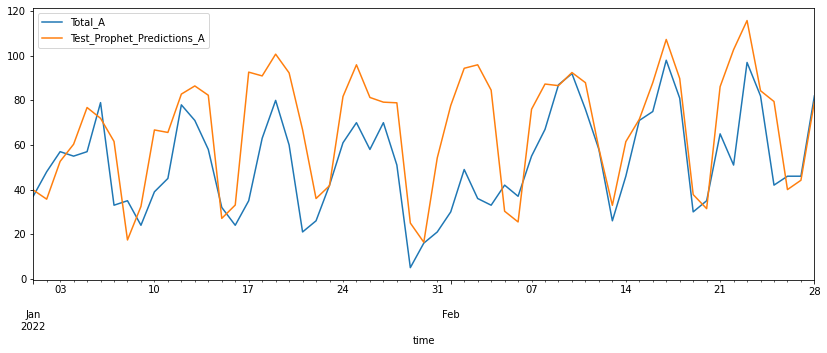

In [141]:
test_prophet_A['Total_A'].plot(figsize=(14,5), legend=True)
prophet_pred_train_A_ex1_2['Test_Prophet_Predictions_A'].plot(legend=True)

<AxesSubplot:xlabel='time'>

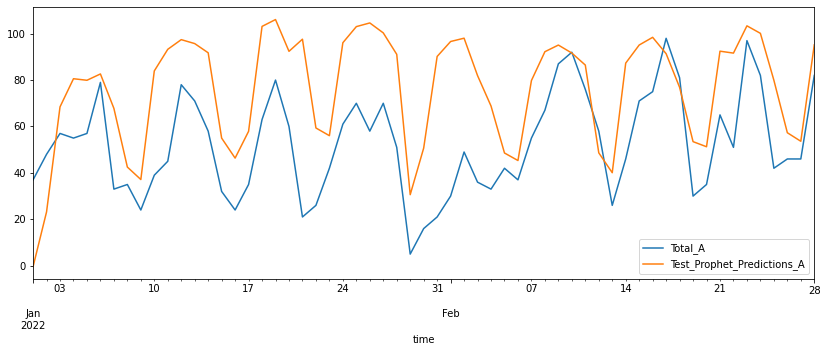

In [142]:
test_prophet_A['Total_A'].plot(figsize=(14,5), legend=True)
prophet_pred_train_A_ex2_2['Test_Prophet_Predictions_A'].plot(legend=True)

<AxesSubplot:xlabel='time'>

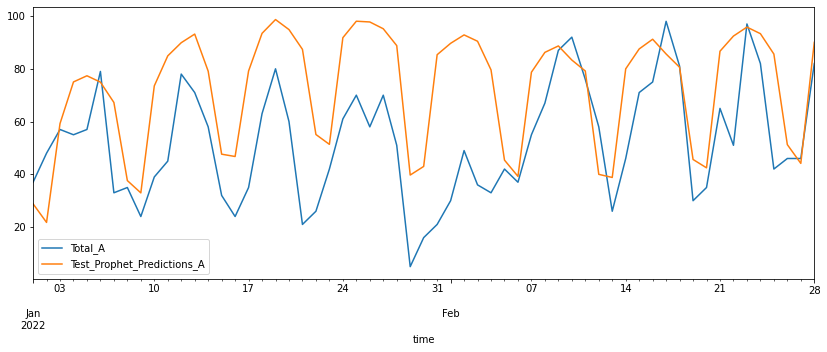

In [143]:
test_prophet_A['Total_A'].plot(figsize=(14,5), legend=True)
prophet_pred_train_A_ex3_2['Test_Prophet_Predictions_A'].plot(legend=True)

--Rückgaben

<AxesSubplot:xlabel='time'>

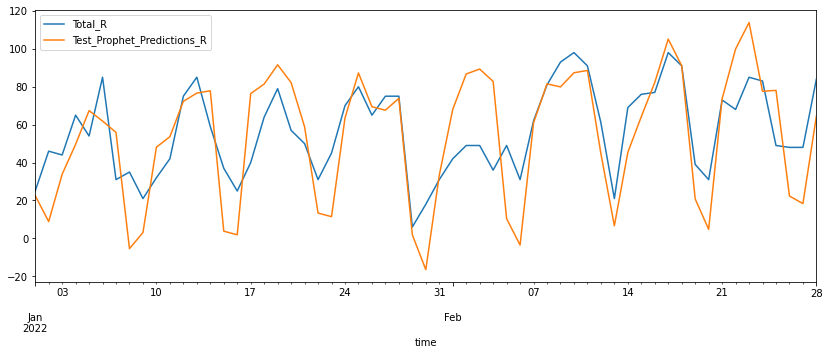

In [144]:
test_prophet_R['Total_R'].plot(figsize=(14,5), legend=True)
prophet_pred_train_R_ex1_2['Test_Prophet_Predictions_R'].plot(legend=True)

<AxesSubplot:xlabel='time'>

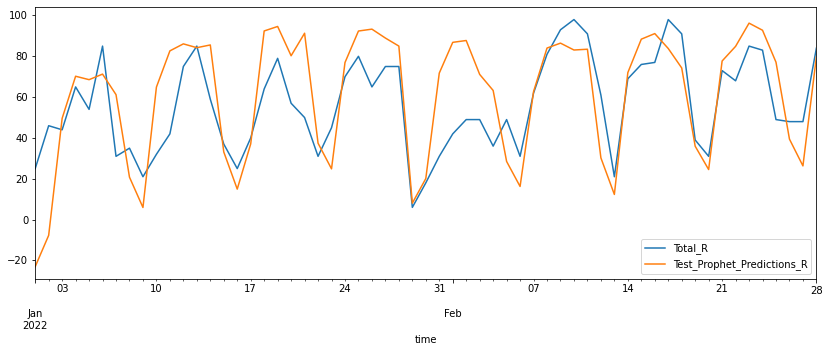

In [145]:
test_prophet_R['Total_R'].plot(figsize=(14,5), legend=True)
prophet_pred_train_R_ex2_2['Test_Prophet_Predictions_R'].plot(legend=True)

<AxesSubplot:xlabel='time'>

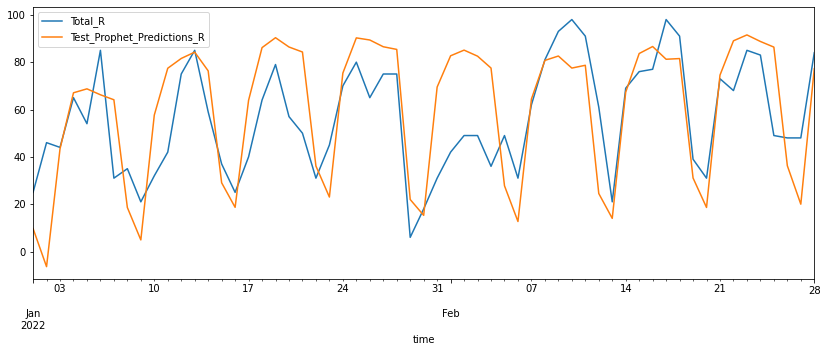

In [146]:
test_prophet_R['Total_R'].plot(figsize=(14,5), legend=True)
prophet_pred_train_R_ex3_2['Test_Prophet_Predictions_R'].plot(legend=True)

---Zusammenführen der Daten von Prophet & ARIMA in einer Tabelle

In [147]:
bike_AP_A = pd.DataFrame()
bike_AP_R = pd.DataFrame()

--Ausleihen

In [148]:
bike_AP_A['Total_A'] = test_arima_A['Total_A']

bike_AP_A['Test_ARIMA_Predictions_A_temp'] = test_arima_A['Test_ARIMA_Predictions_A_temp']
bike_AP_A['Test_Prophet_Predictions_A_temp'] = test_prophet_A['Test_Prophet_Predictions_A_temp']

bike_AP_A['Test_ARIMA_Predictions_A_preci'] = test_arima_A['Test_ARIMA_Predictions_A_preci']
bike_AP_A['Test_Prophet_Predictions_A_preci'] = test_prophet_A['Test_Prophet_Predictions_A_preci']

bike_AP_A['Test_ARIMA_Predictions_A_wind'] = test_arima_A['Test_ARIMA_Predictions_A_wind']
bike_AP_A['Test_Prophet_Predictions_A_wind'] = test_prophet_A['Test_Prophet_Predictions_A_wind']


In [149]:
bike_AP_A.tail()

Total_A  Test_ARIMA_Predictions_A_temp  \
time                                                 
2022-02-24       82                      66.309171   
2022-02-25       42                      56.541930   
2022-02-26       46                      34.916609   
2022-02-27       46                      54.534222   
2022-02-28       82                      57.230969   

            Test_Prophet_Predictions_A_temp  Test_ARIMA_Predictions_A_preci  \
time                                                                          
2022-02-24                        84.335396                       74.428583   
2022-02-25                        79.495650                       50.317611   
2022-02-26                        40.000312                       53.578866   
2022-02-27                        44.183019                       54.538502   
2022-02-28                        79.365446                       62.356000   

            Test_Prophet_Predictions_A_preci  Test_ARIMA_Predictions_A_wind  \
time                                                                          
2022-02-24                        100.140447                      76.674259   
2022-02-25                         79.946439                      63.982552   
2022-02-26                         57.306049                      49.009384   
2022-02-27                         53.625658                      55.022742   
2022-02-28                         95.191881                      65.106953   

            Test_Prophet_Predictions_A_wind  
time                                         
2022-02-24                        93.320970  
2022-02-25                        85.594175  
2022-02-26                        51.254214  
2022-02-27                        44.147540  
2022-02-28                        90.032989

--Rückgaben

In [150]:
bike_AP_R['Total_R'] = test_arima_R['Total_R']

bike_AP_R['Test_ARIMA_Predictions_R_temp'] = test_arima_R['Test_ARIMA_Predictions_R_temp']
bike_AP_R['Test_Prophet_Predictions_R_temp'] = test_prophet_R['Test_Prophet_Predictions_R_temp']

bike_AP_R['Test_ARIMA_Predictions_R_preci'] = test_arima_R['Test_ARIMA_Predictions_R_preci']
bike_AP_R['Test_Prophet_Predictions_R_preci'] = test_prophet_R['Test_Prophet_Predictions_R_preci']

bike_AP_R['Test_ARIMA_Predictions_R_wind'] = test_arima_R['Test_ARIMA_Predictions_R_wind']
bike_AP_R['Test_Prophet_Predictions_R_wind'] = test_prophet_R['Test_Prophet_Predictions_R_wind']

In [151]:
bike_AP_R.tail()

Total_R  Test_ARIMA_Predictions_R_temp  \
time                                                 
2022-02-24       83                      60.506699   
2022-02-25       49                      63.641975   
2022-02-26       48                      30.148403   
2022-02-27       48                      44.030964   
2022-02-28       84                      57.826023   

            Test_Prophet_Predictions_R_temp  Test_ARIMA_Predictions_R_preci  \
time                                                                          
2022-02-24                        77.572778                       71.860572   
2022-02-25                        78.088136                       60.078616   
2022-02-26                        22.348957                       51.818456   
2022-02-27                        18.360347                       46.537896   
2022-02-28                        64.525595                       66.382097   

            Test_Prophet_Predictions_R_preci  Test_ARIMA_Predictions_R_wind  \
time                                                                          
2022-02-24                         92.761928                      63.859648   
2022-02-25                         77.105268                      60.869052   
2022-02-26                         39.429075                      38.326356   
2022-02-27                         26.314463                      31.206680   
2022-02-28                         79.761649                      60.461817   

            Test_Prophet_Predictions_R_wind  
time                                         
2022-02-24                        88.740898  
2022-02-25                        86.362791  
2022-02-26                        36.253823  
2022-02-27                        20.009380  
2022-02-28                        77.235159

---Vergleich von Prophet & ARIMA in einer Grafik mit dem jeweiligen Fehlermaß

--Ausleihen

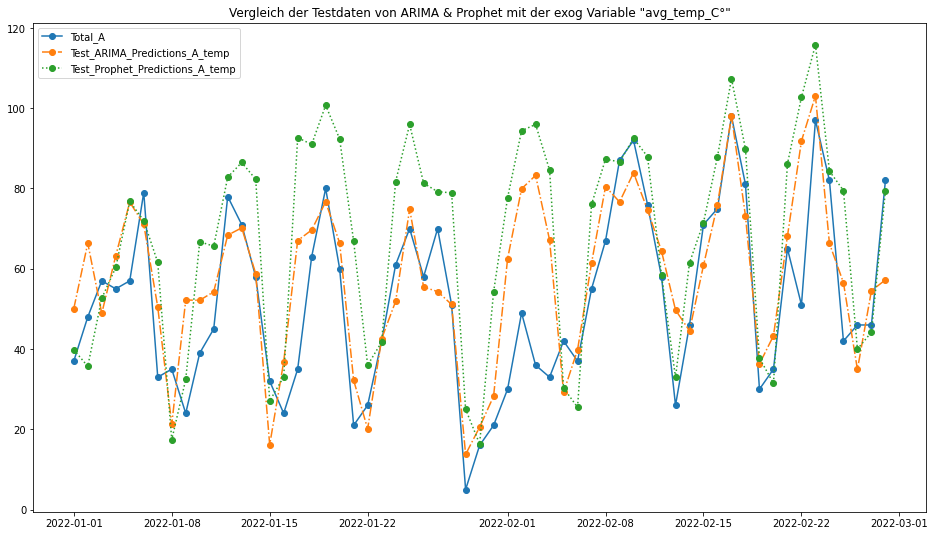

In [152]:
rmse_errors_A_ex1 = [test_arima_rmse_error_A_ex1, test_prophet_rmse_error_A_ex1]
mse_errors_A_ex1 = [test_arima_mse_error_A_ex1, test_prophet_mse_error_A_ex1]
mape_errors_A_ex1 = [test_arima_mape_error_A_ex1, test_prophet_mape_error_A_ex1]
errors_A_ex1 = pd.DataFrame({"Models" : ["ARIMA", "Prophet"],"RMSE Errors" : rmse_errors_A_ex1, "MSE Errors" : mse_errors_A_ex1, 'MAPE Errors': mape_errors_A_ex1})
plt.figure(figsize=(16,9))
plt.plot_date(bike_AP_A.index, bike_AP_A["Total_A"], linestyle="-")
plt.plot_date(bike_AP_A.index, bike_AP_A["Test_ARIMA_Predictions_A_temp"], linestyle="-.")
plt.plot_date(bike_AP_A.index, bike_AP_A["Test_Prophet_Predictions_A_temp"], linestyle=":")
plt.legend(labels=['Total_A', 'Test_ARIMA_Predictions_A_temp', 'Test_Prophet_Predictions_A_temp'])
plt.title('Vergleich der Testdaten von ARIMA & Prophet mit der exog Variable "avg_temp_C°"')
plt.show()

In [153]:
errors_A_ex1

Models  RMSE Errors  MSE Errors  MAPE Errors
0    ARIMA    15.830284  250.597899    11.967860
1  Prophet    23.752727  564.192034    17.938109

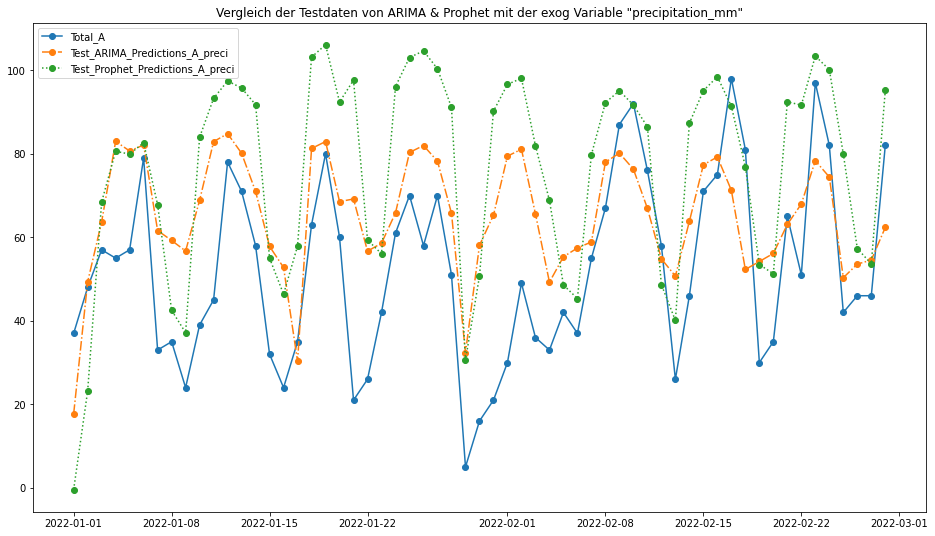

In [154]:
rmse_errors_A_ex2 = [test_arima_rmse_error_A_ex2, test_prophet_rmse_error_A_ex2]
mse_errors_A_ex2 = [test_arima_mse_error_A_ex2, test_prophet_mse_error_A_ex2]
mape_errors_A_ex2 = [test_arima_mape_error_A_ex2, test_prophet_mape_error_A_ex2]
errors_A_ex2 = pd.DataFrame({"Models" : ["ARIMA", "Prophet"],"RMSE Errors" : rmse_errors_A_ex2, "MSE Errors" : mse_errors_A_ex2, 'MAPE Errors': mape_errors_A_ex2})
plt.figure(figsize=(16,9))
plt.plot_date(bike_AP_A.index, bike_AP_A["Total_A"], linestyle="-")
plt.plot_date(bike_AP_A.index, bike_AP_A["Test_ARIMA_Predictions_A_preci"], linestyle="-.")
plt.plot_date(bike_AP_A.index, bike_AP_A["Test_Prophet_Predictions_A_preci"], linestyle=":")
plt.legend(labels=['Total_A', 'Test_ARIMA_Predictions_A_preci', 'Test_Prophet_Predictions_A_preci'])
plt.title('Vergleich der Testdaten von ARIMA & Prophet mit der exog Variable "precipitation_mm"')
plt.show()

In [155]:
errors_A_ex2

Models  RMSE Errors  MSE Errors  MAPE Errors
0    ARIMA    21.930239  480.935402    18.275743
1  Prophet    31.177173  972.016122    26.519175

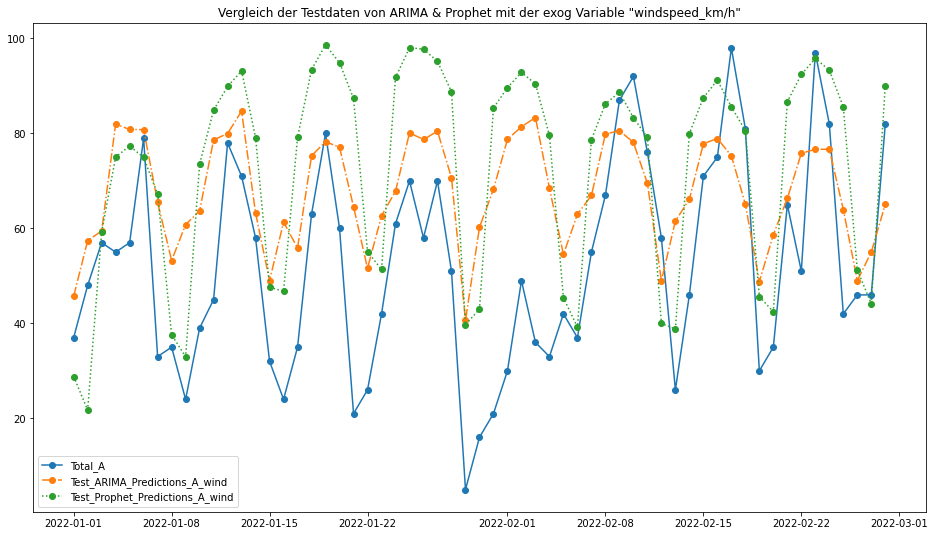

In [156]:
rmse_errors_A_ex3 = [test_arima_rmse_error_A_ex3, test_prophet_rmse_error_A_ex3]
mse_errors_A_ex3 = [test_arima_mse_error_A_ex3, test_prophet_mse_error_A_ex3]
mape_errors_A_ex3 = [test_arima_mape_error_A_ex3, test_prophet_mape_error_A_ex3]
errors_A_ex3 = pd.DataFrame({"Models" : ["ARIMA", "Prophet"],"RMSE Errors" : rmse_errors_A_ex3, "MSE Errors" : mse_errors_A_ex3, 'MAPE Errors': mape_errors_A_ex3})
plt.figure(figsize=(16,9))
plt.plot_date(bike_AP_A.index, bike_AP_A["Total_A"], linestyle="-")
plt.plot_date(bike_AP_A.index, bike_AP_A["Test_ARIMA_Predictions_A_wind"], linestyle="-.")
plt.plot_date(bike_AP_A.index, bike_AP_A["Test_Prophet_Predictions_A_wind"], linestyle=":")
plt.legend(labels=['Total_A', 'Test_ARIMA_Predictions_A_wind', 'Test_Prophet_Predictions_A_wind'])
plt.title('Vergleich der Testdaten von ARIMA & Prophet mit der exog Variable "windspeed_km/h"')
plt.show()

In [157]:
errors_A_ex3

Models  RMSE Errors  MSE Errors  MAPE Errors
0    ARIMA    23.293067  542.566949    19.398838
1  Prophet    28.317042  801.854865    22.880281

--Rückgaben

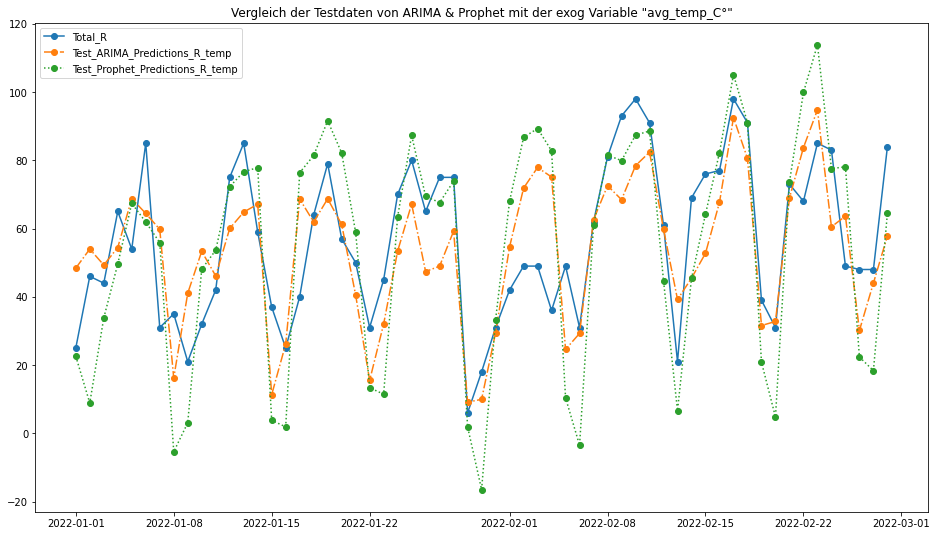

In [158]:
rmse_errors_R_ex1 = [test_arima_rmse_error_R_ex1, test_prophet_rmse_error_R_ex1]
mse_errors_R_ex1 = [test_arima_mse_error_R_ex1, test_prophet_mse_error_R_ex1]
mape_errors_R_ex1 = [test_arima_mape_error_R_ex1, test_prophet_mape_error_R_ex1]
errors_R_ex1 = pd.DataFrame({"Models" : ["ARIMA", "Prophet"],"RMSE Errors" : rmse_errors_R_ex1, "MSE Errors" : mse_errors_R_ex1, 'MAPE Errors': mape_errors_R_ex1})
plt.figure(figsize=(16,9))
plt.plot_date(bike_AP_R.index, bike_AP_R["Total_R"], linestyle="-")
plt.plot_date(bike_AP_R.index, bike_AP_R["Test_ARIMA_Predictions_R_temp"], linestyle="-.")
plt.plot_date(bike_AP_R.index, bike_AP_R["Test_Prophet_Predictions_R_temp"], linestyle=":")
plt.legend(labels=['Total_R', 'Test_ARIMA_Predictions_R_temp', 'Test_Prophet_Predictions_R_temp'])
plt.title('Vergleich der Testdaten von ARIMA & Prophet mit der exog Variable "avg_temp_C°"')
plt.show()

In [159]:
errors_R_ex1

Models  RMSE Errors  MSE Errors  MAPE Errors
0    ARIMA    16.768384  281.178713    14.186936
1  Prophet    22.008601  484.378505    18.020347

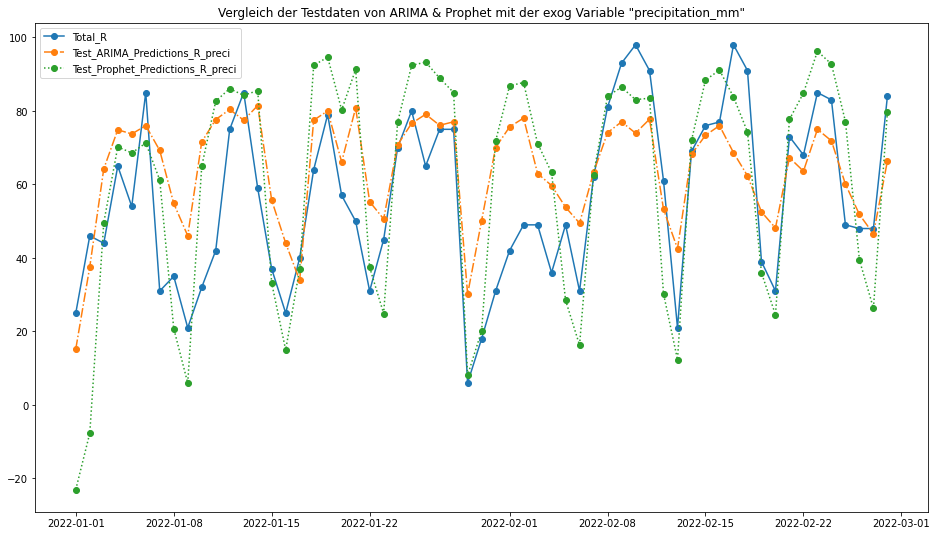

In [160]:
rmse_errors_R_ex2 = [test_arima_rmse_error_R_ex2, test_prophet_rmse_error_R_ex2]
mse_errors_R_ex2 = [test_arima_mse_error_R_ex2, test_prophet_mse_error_R_ex2]
mape_errors_R_ex2 = [test_arima_mape_error_R_ex2, test_prophet_mape_error_R_ex2]
errors_R_ex2 = pd.DataFrame({"Models" : ["ARIMA", "Prophet"],"RMSE Errors" : rmse_errors_R_ex2, "MSE Errors" : mse_errors_R_ex2, 'MAPE Errors': mape_errors_R_ex2})
plt.figure(figsize=(16,9))
plt.plot_date(bike_AP_R.index, bike_AP_R["Total_R"], linestyle="-")
plt.plot_date(bike_AP_R.index, bike_AP_R["Test_ARIMA_Predictions_R_preci"], linestyle="-.")
plt.plot_date(bike_AP_R.index, bike_AP_R["Test_Prophet_Predictions_R_preci"], linestyle=":")
plt.legend(labels=['Total_R', 'Test_ARIMA_Predictions_R_preci', 'Test_Prophet_Predictions_R_preci'])
plt.title('Vergleich der Testdaten von ARIMA & Prophet mit der exog Variable "precipitation_mm"')
plt.show()

In [161]:
errors_R_ex2

Models  RMSE Errors  MSE Errors  MAPE Errors
0    ARIMA    18.671495  348.624708    15.056784
1  Prophet    21.354773  456.026346    16.887094

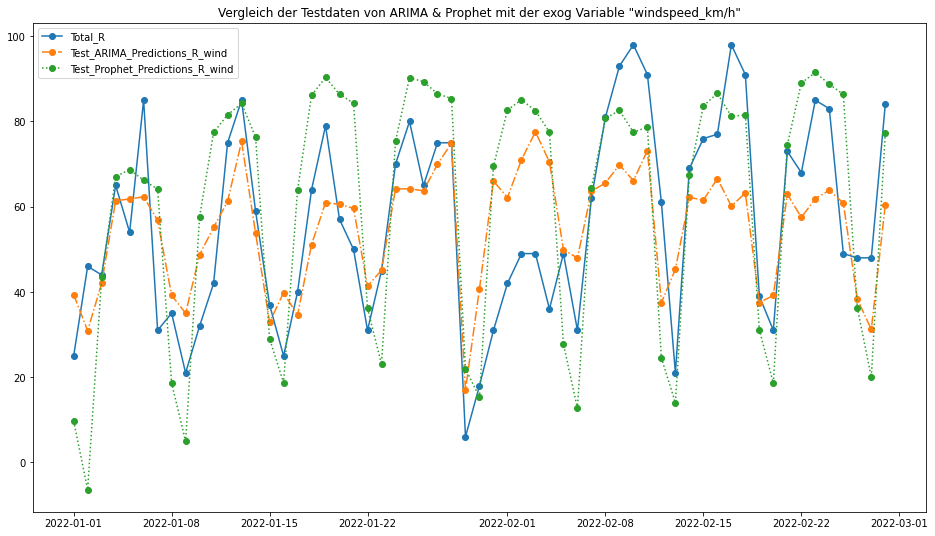

In [162]:
rmse_errors_R_ex3 = [test_arima_rmse_error_R_ex3, test_prophet_rmse_error_R_ex3]
mse_errors_R_ex3 = [test_arima_mse_error_R_ex3, test_prophet_mse_error_R_ex3]
mape_errors_R_ex3 = [test_arima_mape_error_R_ex3, test_prophet_mape_error_R_ex3]
errors_R_ex3 = pd.DataFrame({"Models" : ["ARIMA", "Prophet"],"RMSE Errors" : rmse_errors_R_ex3, "MSE Errors" : mse_errors_R_ex3, 'MAPE Errors': mape_errors_R_ex3})
plt.figure(figsize=(16,9))
plt.plot_date(bike_AP_R.index, bike_AP_R["Total_R"], linestyle="-")
plt.plot_date(bike_AP_R.index, bike_AP_R["Test_ARIMA_Predictions_R_wind"], linestyle="-.")
plt.plot_date(bike_AP_R.index, bike_AP_R["Test_Prophet_Predictions_R_wind"], linestyle=":")
plt.legend(labels=['Total_R', 'Test_ARIMA_Predictions_R_wind', 'Test_Prophet_Predictions_R_wind'])
plt.title('Vergleich der Testdaten von ARIMA & Prophet mit der exog Variable "windspeed_km/h"')
plt.show()

In [163]:
errors_R_ex3

Models  RMSE Errors  MSE Errors  MAPE Errors
0    ARIMA    17.011751  289.399681    14.173578
1  Prophet    21.101055  445.254543    16.976830